## Plan
Basen on the characteristics of the the problem (Binary Classification, not balanced), and
the tools being use, the plan is to:
- Observe distributions, central tendency, dispertion and location.
- Transform categorical variables to binary.
- Deal with outliers of the continious variables, [winsorize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.winsorize.html)
- Scale Continious varibles. [scale 0/1](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Input missing values with knn inputer.
- Upsample the minority class
- As well as verify assumptions of linear regression.

I will verifying as we go and there is no particular order and may comeback iteratively.

In [57]:
import exploratory_data_analysis.eda_functions as eda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
## metrics
from sklearn.metrics import accuracy_score,\
recall_score, precision_score, f1_score,\
confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.utils import resample

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import scipy
from scipy import stats
from scipy.stats.mstats import winsorize

import warnings as cuidado
cuidado.filterwarnings('ignore')

In [58]:
df = pd.read_csv('waze_dataset.csv')
df.drop(['ID'], inplace=True, axis=1)

In [59]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [60]:
##EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    14299 non-null  object 
 1   sessions                 14999 non-null  int64  
 2   drives                   14999 non-null  int64  
 3   total_sessions           14999 non-null  float64
 4   n_days_after_onboarding  14999 non-null  int64  
 5   total_navigations_fav1   14999 non-null  int64  
 6   total_navigations_fav2   14999 non-null  int64  
 7   driven_km_drives         14999 non-null  float64
 8   duration_minutes_drives  14999 non-null  float64
 9   activity_days            14999 non-null  int64  
 10  driving_days             14999 non-null  int64  
 11  device                   14999 non-null  object 
dtypes: float64(3), int64(7), object(2)
memory usage: 1.4+ MB


In [61]:
## Unique elements per column
[len(df[i].unique()) for i in df.columns]

[3, 469, 401, 14999, 3441, 730, 287, 14999, 14999, 32, 31, 2]

In [62]:
## three classes ???
df['label'].unique()

array(['retained', 'churned', nan], dtype=object)

In [63]:
## observing missing values and invalid values
#help(eda.get_invalid_values)
eda.get_invalid_values(df).iloc[:, 1:]

,nulls,invalids,unique_item
label,700,700,"[retained, churned, nan]"
sessions,0,0,"[283, 133, 114, 49, 84, 113, 3, 39, 57, 23, 12..."
drives,0,0,"[226, 107, 95, 40, 68, 103, 2, 35, 46, 20, 100..."
total_sessions,0,0,"[296.7482729, 326.8965962, 135.5229263, 67.589..."
n_days_after_onboarding,0,0,"[2276, 1225, 2651, 15, 1562, 2637, 360, 2999, ..."
total_navigations_fav1,0,0,"[208, 19, 0, 322, 166, 185, 72, 3, 64, 39, 54,..."
total_navigations_fav2,0,0,"[0, 64, 7, 5, 18, 26, 36, 16, 24, 19, 90, 11, ..."
driven_km_drives,0,0,"[2628.845068, 13715.92055, 3059.148818, 913.59..."
duration_minutes_drives,0,0,"[1985.775061, 3160.472914, 1610.735904, 587.19..."
activity_days,0,0,"[28, 13, 14, 7, 27, 15, 22, 25, 9, 1, 12, 0, 1..."


In [64]:
## count of the target.
df['label'].value_counts()

retained    11763
churned      2536
Name: label, dtype: int64

In [65]:
## Data by data type.
nums = eda.sift_data_type(df)['nums']
cats = eda.sift_data_type(df)['objs']

------- CLASS COUNTS --------------------

---------LABEL--------------------
retained    11763
churned      2536
Name: label, dtype: int64
2536, is: 17.7355% of the total
11763, is: 82.2645% of the total
not balance, unfortunately This is not the way
------------------------------------------
count        14299
unique           2
top       retained
freq         11763
Name: label, dtype: object
------------------------------------------
---------DEVICE--------------------
iPhone     9672
Android    5327
Name: device, dtype: int64
5327, is: 35.5157% of the total
9672, is: 64.4843% of the total
not balance, unfortunately This is not the way
------------------------------------------
count      14999
unique         2
top       iPhone
freq        9672
Name: device, dtype: object
------------------------------------------


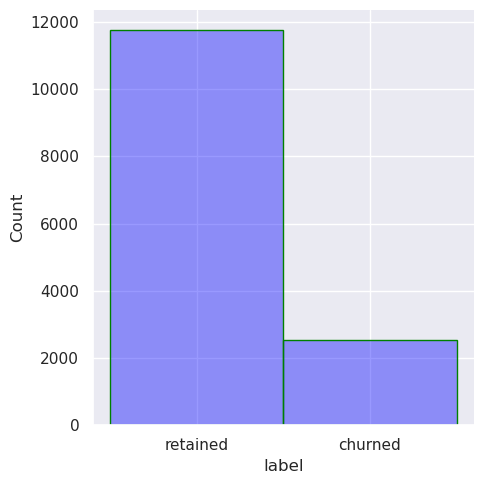

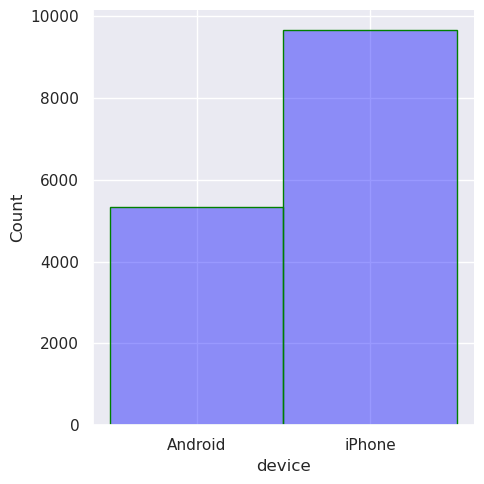

In [66]:
## Balance checking

def pct_checker(percentage, min_percentage, max_percentage):
    if percentage >= min_percentage and percentage <= max_percentage:
        return ('This is the way, balance')
    else:
        return ('not balance, unfortunately This is not the way')

print('------- CLASS COUNTS --------------------')
print()
for obj in cats:
    sns.displot(df, x=obj, color='blue', edgecolor='green', alpha=0.4)
    print(f'---------{str.upper(obj)}--------------------')
    print(df[obj].value_counts())
    
    a = df[obj].value_counts()[0]
    b = df[obj].value_counts()[1]
    pct_a = a / ( a + b ) * 100
    pct_b = b / ( a + b ) * 100
    
    print(f'{b}, is: {round(pct_b, 4)}% of the total')
    print(f'{a}, is: {round(pct_a, 4)}% of the total')
    
    ##
    ## As pct depend of each other we just need one check
    print(pct_checker(pct_a, 40, 60))
 
    print('------------------------------------------')
    print(df[obj].describe())
    print('------------------------------------------')

In [67]:
## Filling in missing values as objective, and coming soon
## Transformation into a binary class first.
df.loc[df['label'] == 'churned', 'label'] = 0
df.loc[df['label'] == 'retained', 'label'] = 1
df.loc[df['device'] == 'iPhone', 'device'] = 0
df.loc[df['device'] == 'Android', 'device'] = 1

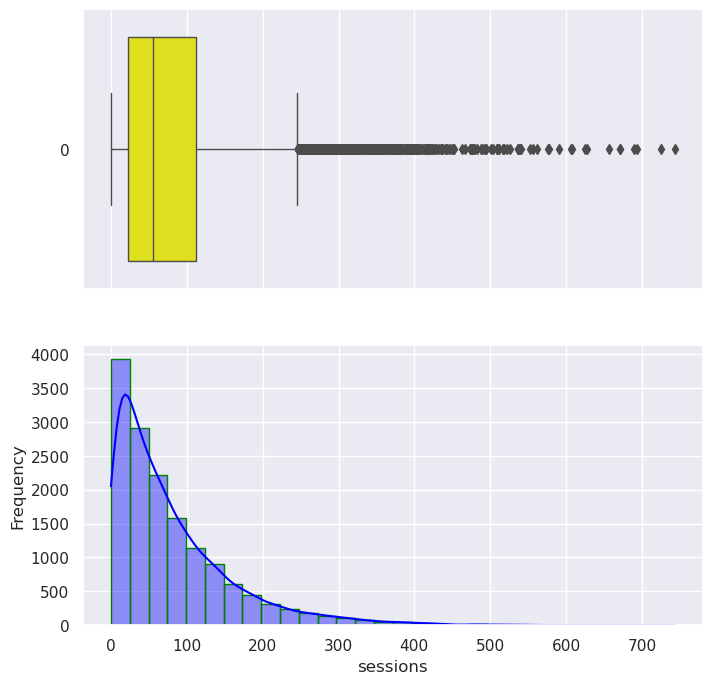

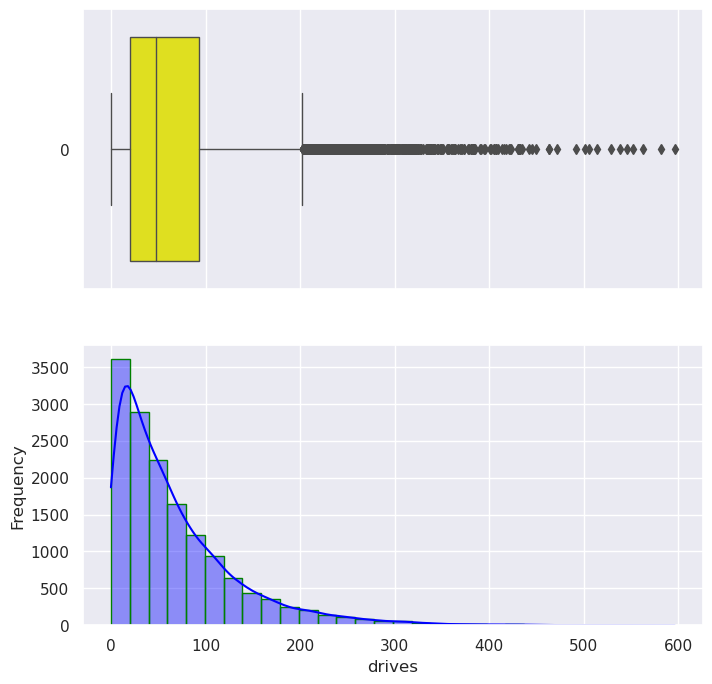

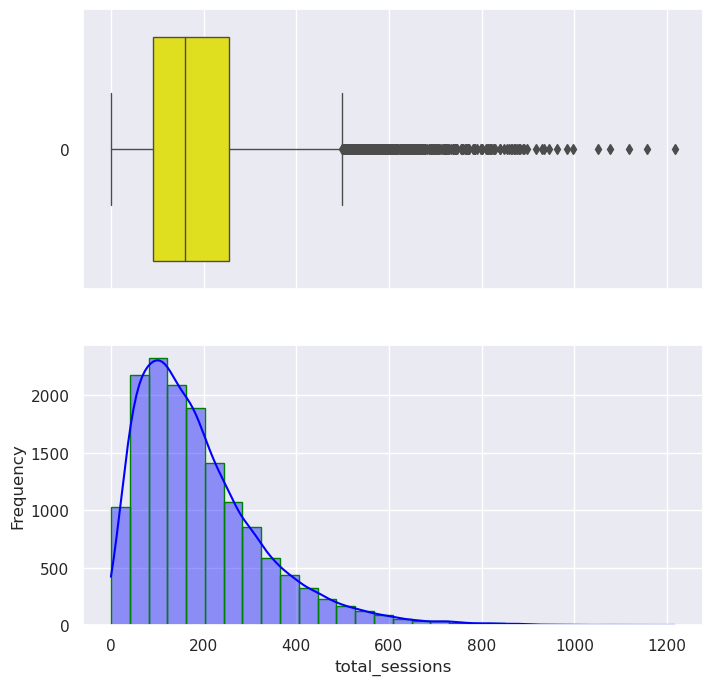

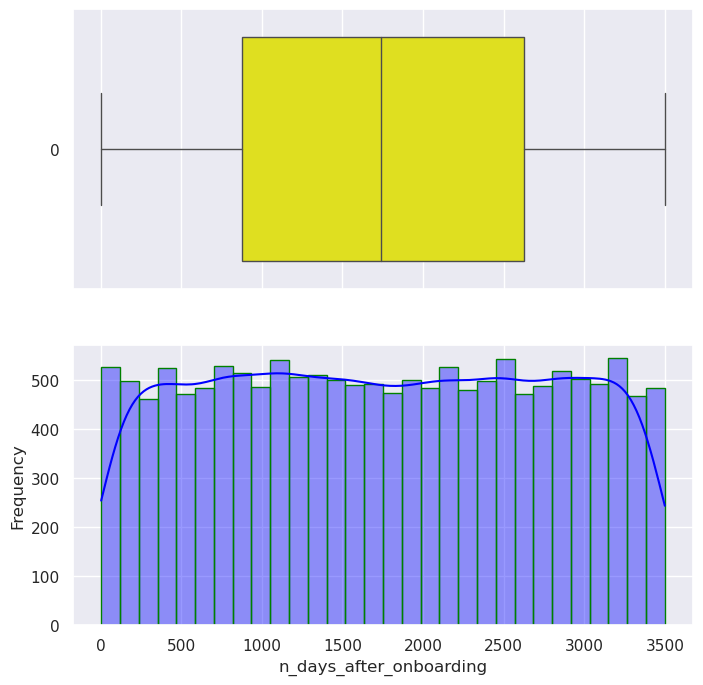

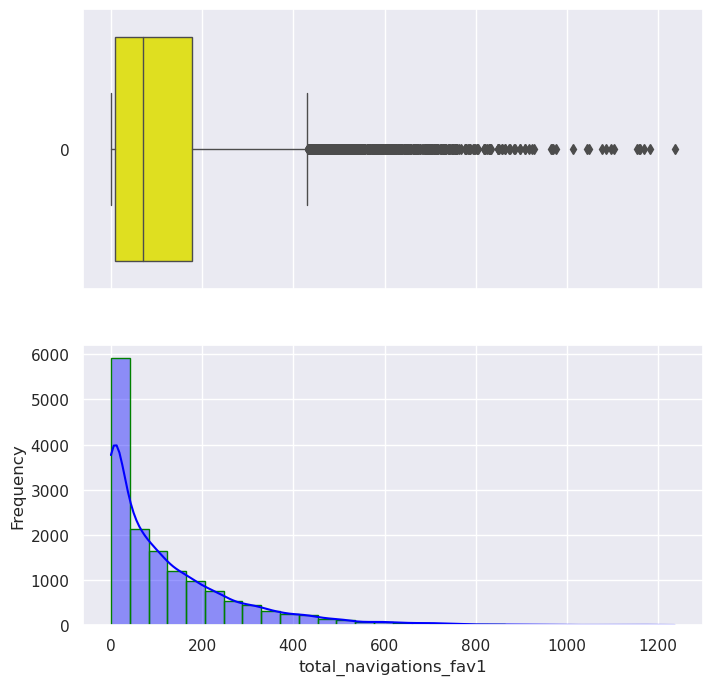

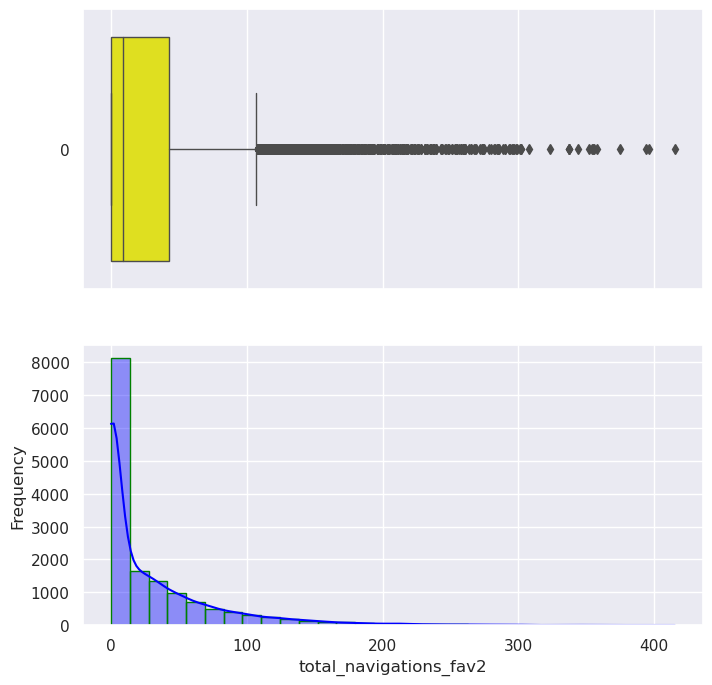

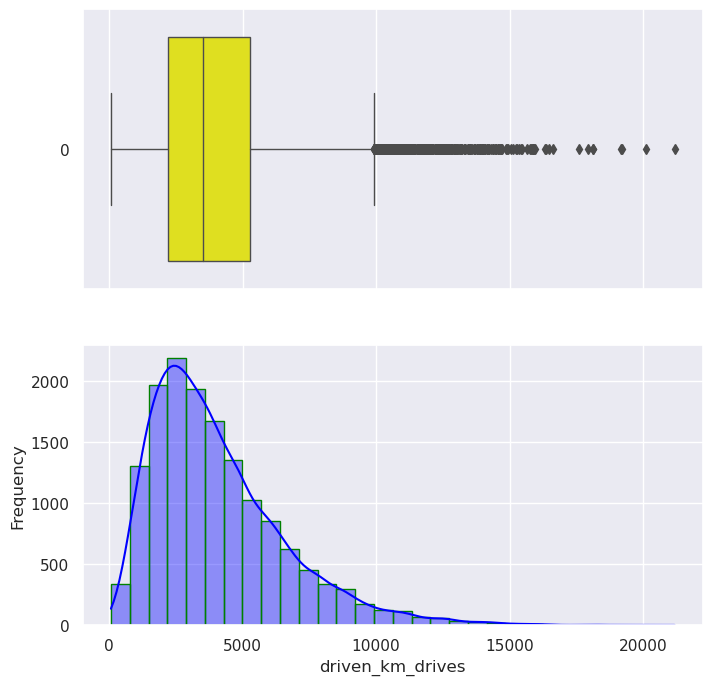

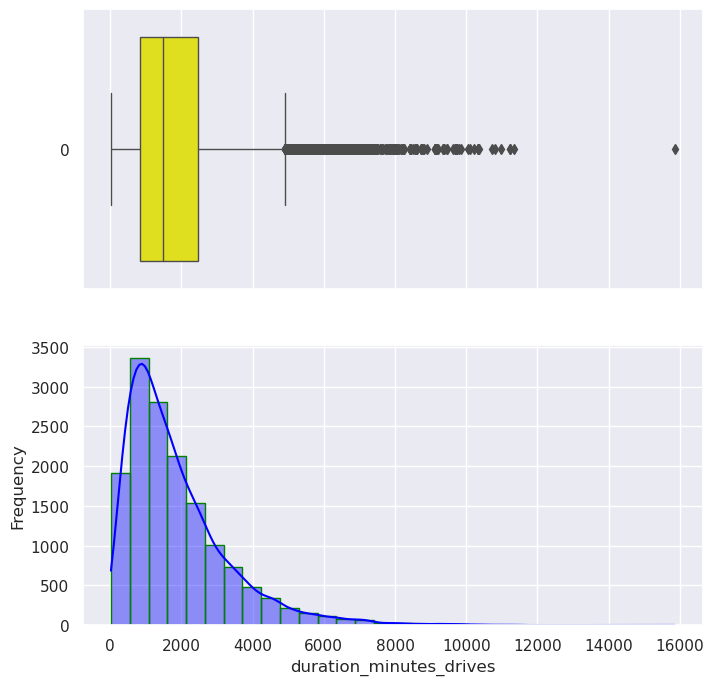

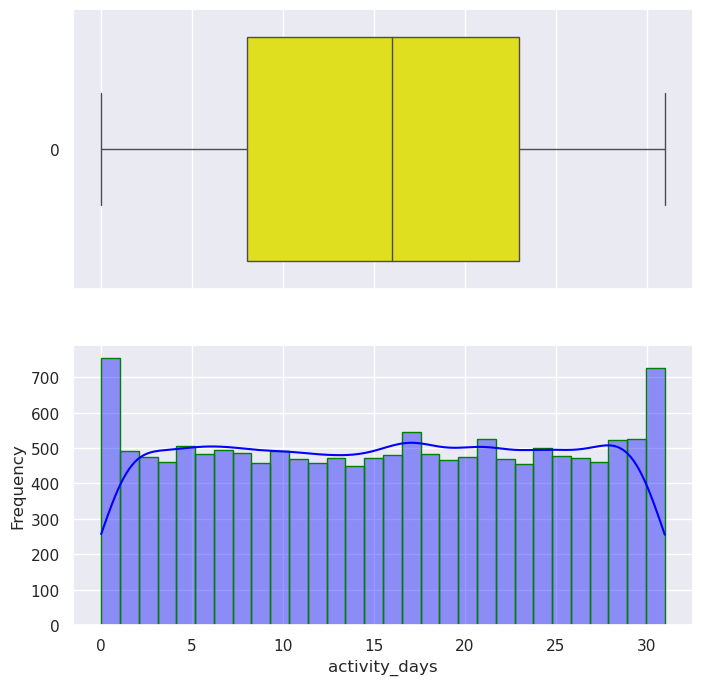

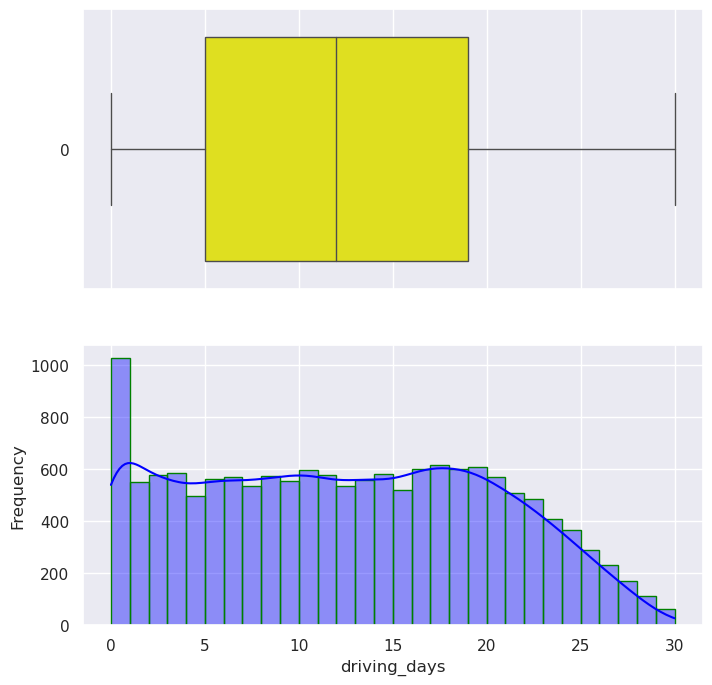

In [68]:
## Observing Distribution of the continious variables.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

## Outliers keep or take out?

The initial observations have been made

In [69]:
## filtering the outliers.

not_transformation = ['n_days_after_onboarding', 'activity_days', 'driving_days']
to_transform = nums ^ not_transformation
to_transform

Index(['driven_km_drives', 'drives', 'duration_minutes_drives', 'sessions',
       'total_navigations_fav1', 'total_navigations_fav2', 'total_sessions'],
      dtype='object')

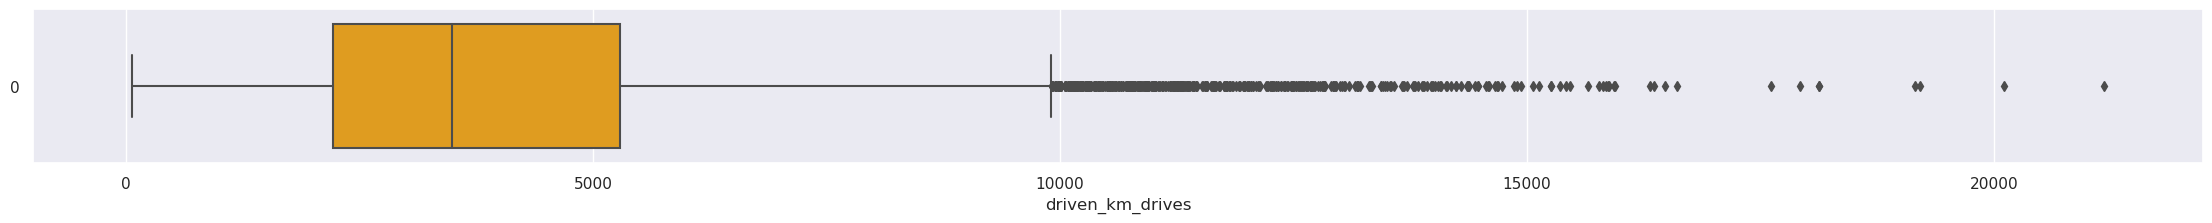

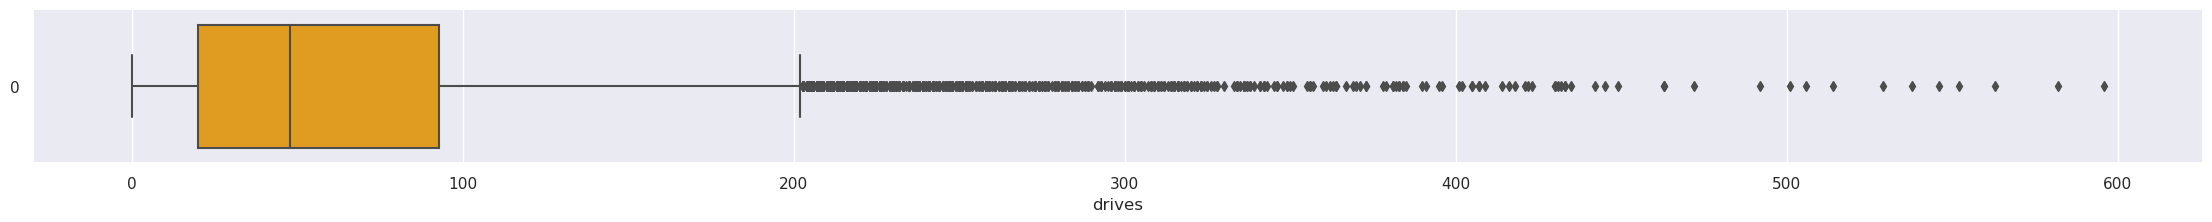

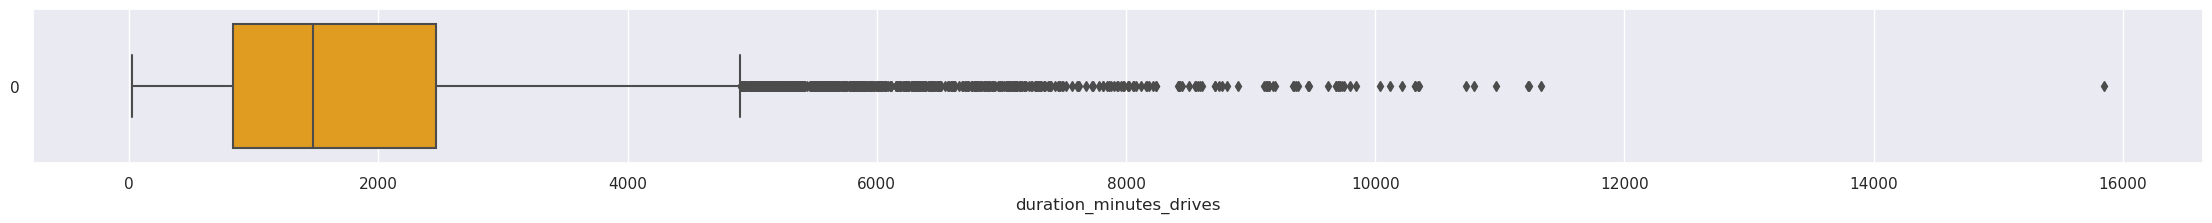

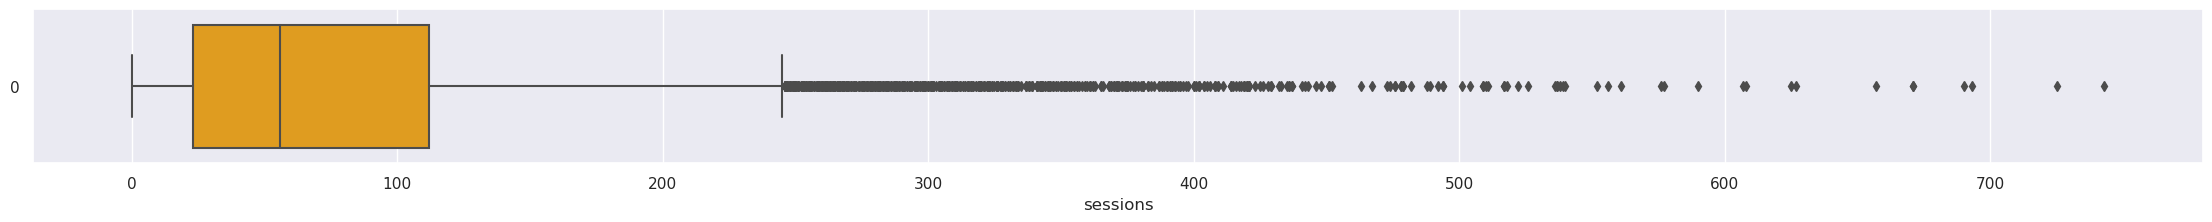

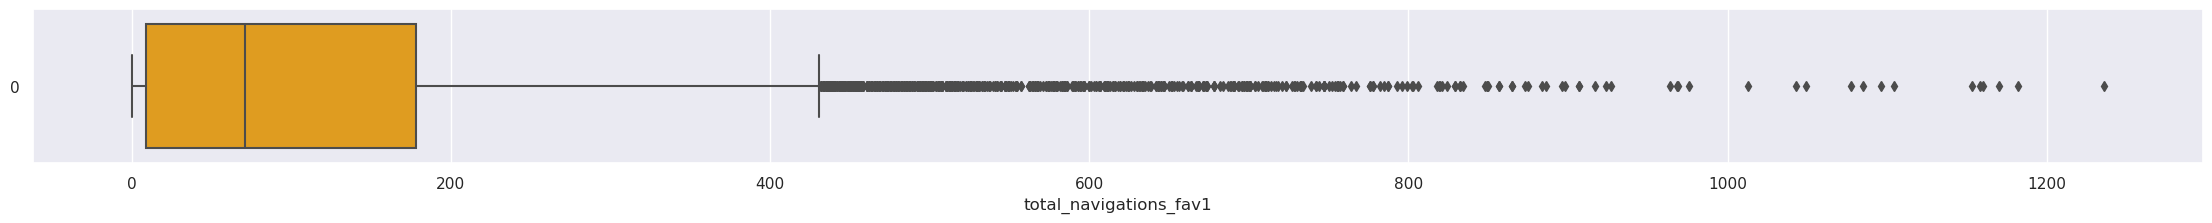

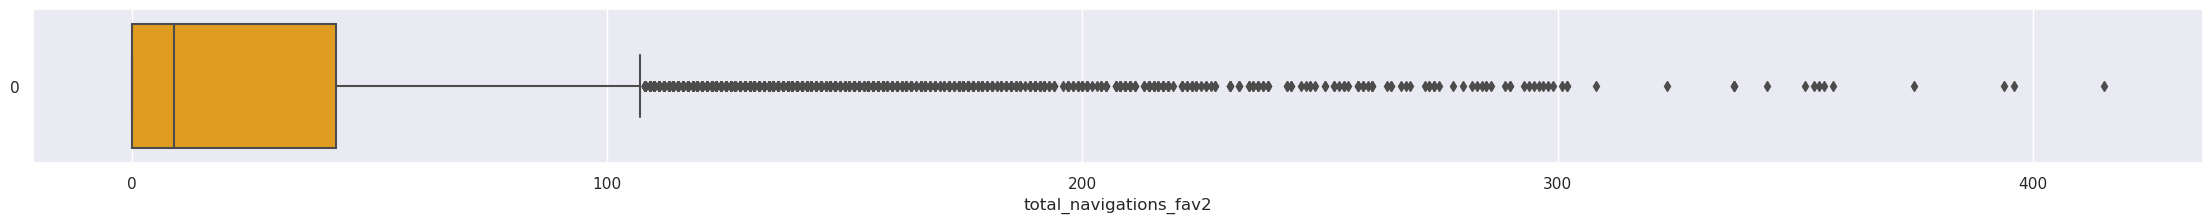

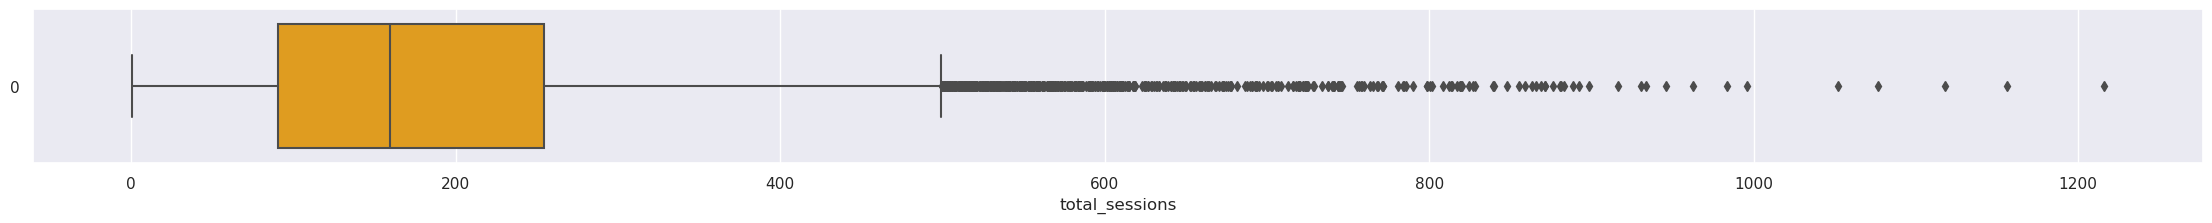

In [70]:
for i in to_transform:
    plt.figure(figsize = (28, 2))
    sns.boxplot(data=df[i], orient='h', color='orange');
    plt.xlabel(i)
    plt.show()

### Transformation of the continious variables

In [71]:
for j in to_transform:    
    df[j] =  winsorize(df[j], limits=(0.05, 0.05))

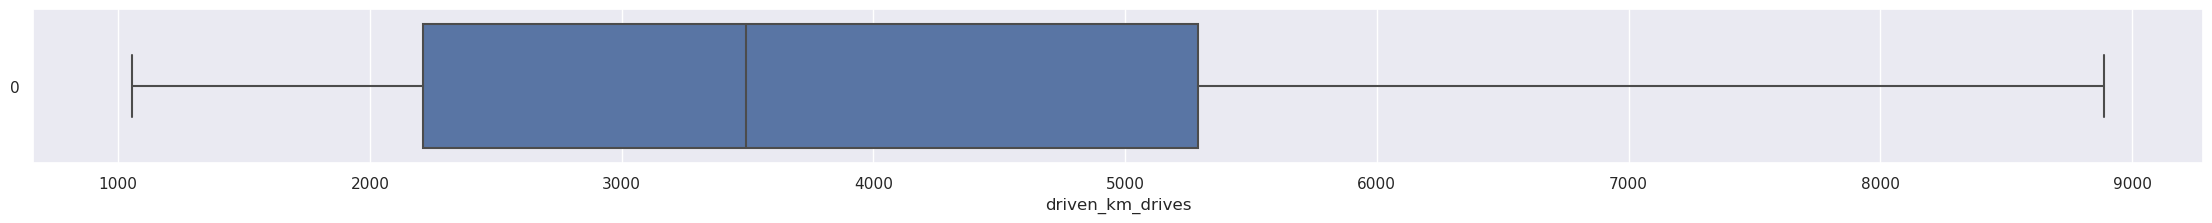

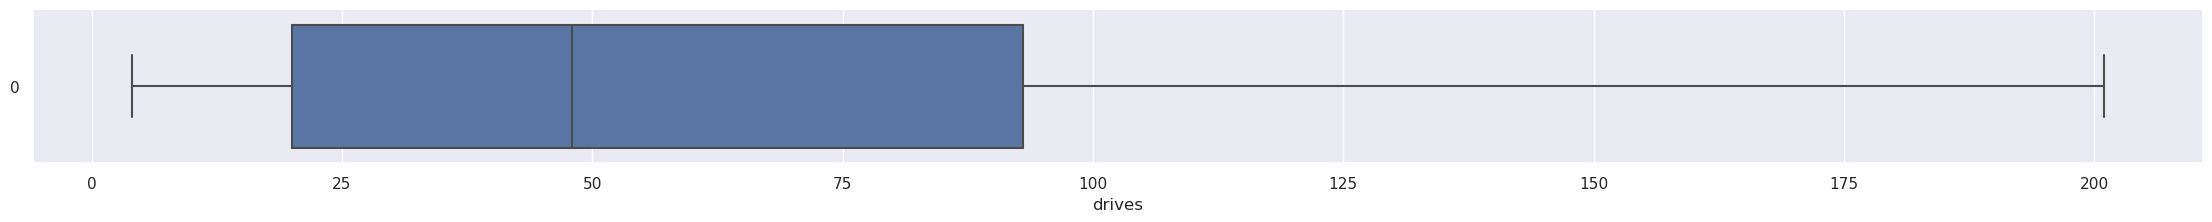

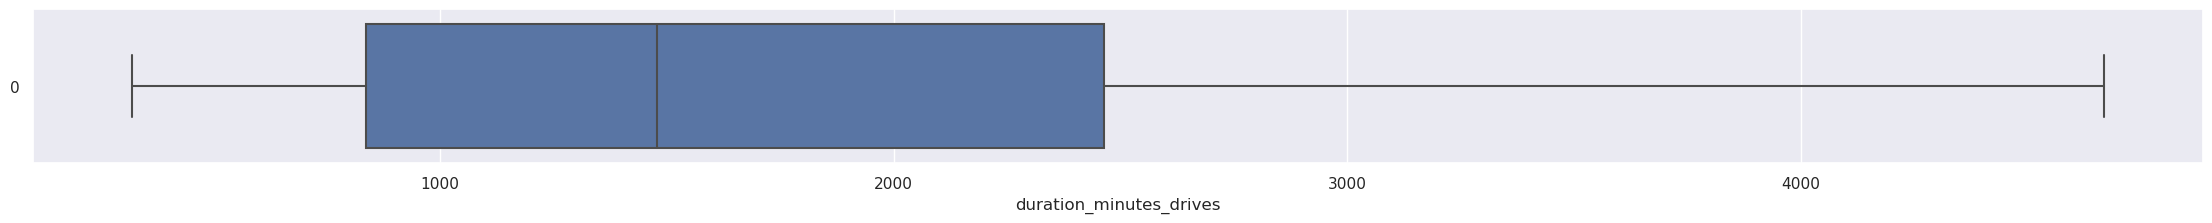

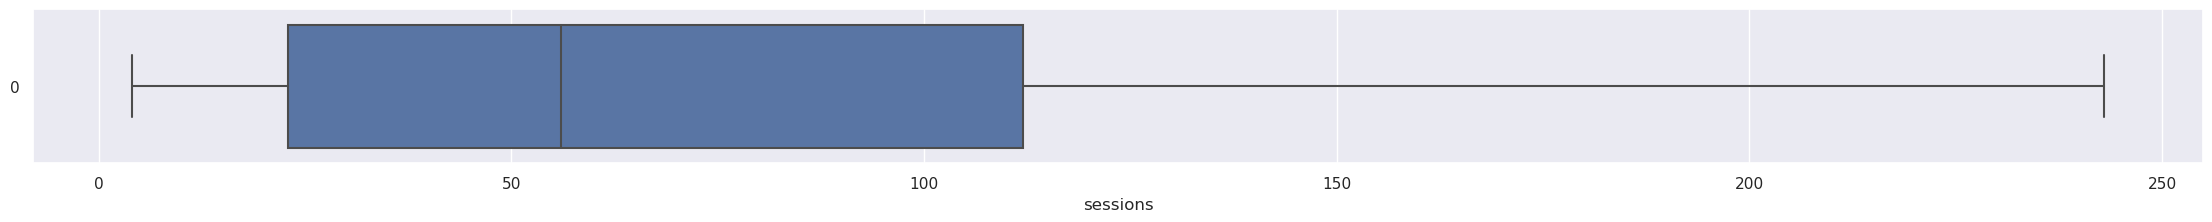

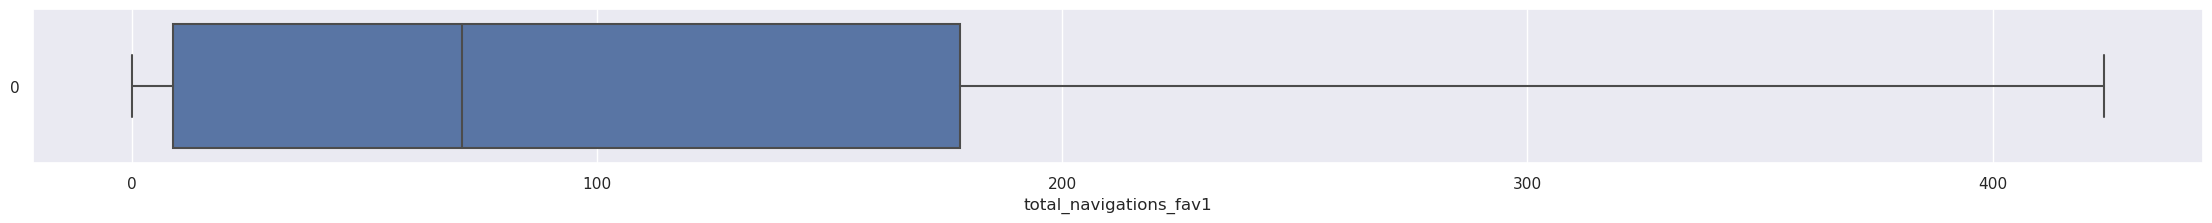

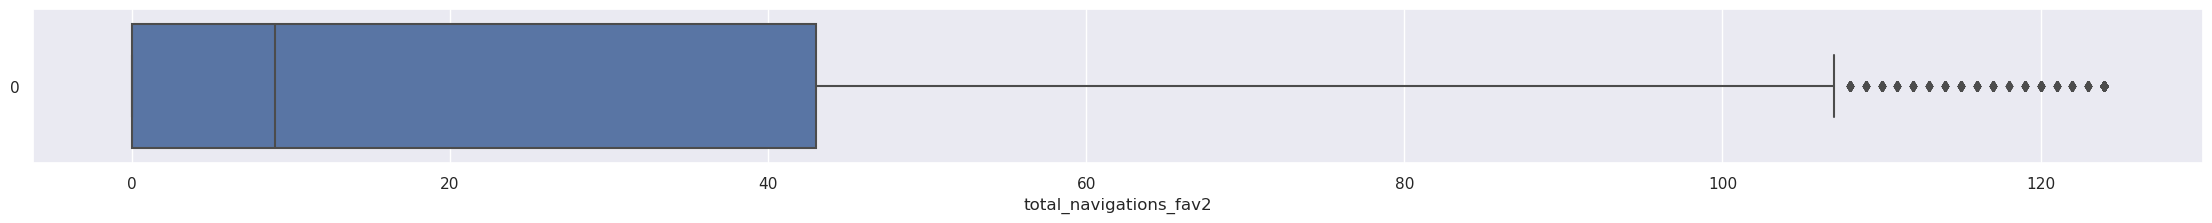

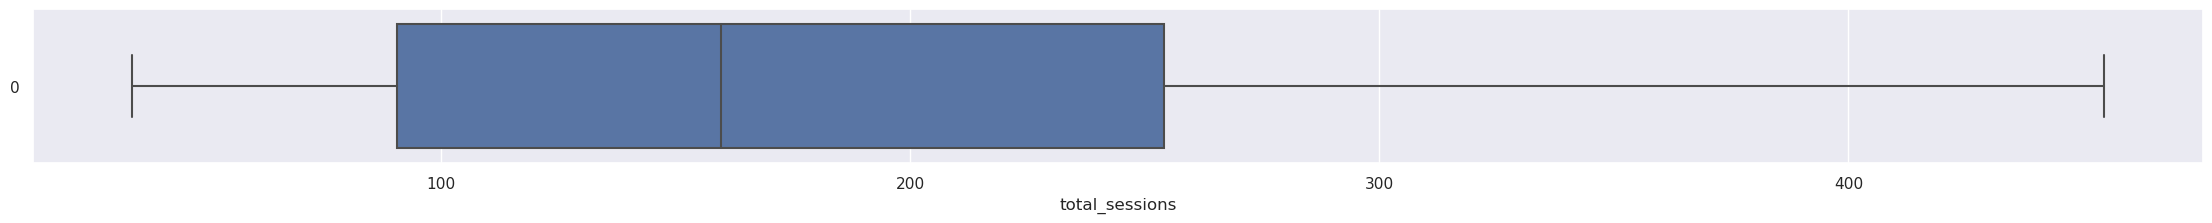

In [72]:
## check transformations

for i in to_transform:
    plt.figure(figsize = (28, 2))
    sns.boxplot(data=df[i], orient='h');
    plt.xlabel(i)
    plt.show()

## Filling in values with a logistic regression

In [73]:
df.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,1,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1
1,1,133,107,326.896596,1225,19,64,8889.959985,3160.472914,13,11,0
2,1,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1
3,1,49,40,67.589221,15,322,7,1053.137744,587.196542,7,3,0
4,1,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1


In [74]:
eda.miss_df(df)

,Total,Percent
label,700,4.666978
sessions,0,0.000000
drives,0,0.000000
total_sessions,0,0.000000
n_days_after_onboarding,0,0.000000
total_navigations_fav1,0,0.000000
total_navigations_fav2,0,0.000000
driven_km_drives,0,0.000000
duration_minutes_drives,0,0.000000
activity_days,0,0.000000


## Filling in missing values using logistic regression.
1. Separate into train(non missing) and test(missing)
2. Separate into X_test, X_train, y_test, y_train
3. Fit the linear regression model
4. Make prediction with X_train 
5. obtain the prediction
6. create a data set with the prediction filling the respective nans

In [75]:
## separate into train and tets
miss_test = df[pd.isnull(df['label'])]
non_miss_train = df[~pd.isnull(df['label'])]

In [76]:
## separate into Xm_test, Xn_train, ym_test, yn_train
## Xm_test
miss_test
Xm_test = miss_test.iloc[:, 1:]
ym_test = miss_test.iloc[:, 0]
non_miss_train
Xn_train = non_miss_train.iloc[:, 1:]
yn_train = non_miss_train.iloc[:, 0]

In [77]:
yn_train = list(yn_train.values)

In [78]:
lr_fill = LogisticRegression()
lr_fill.fit(Xn_train, yn_train)

LogisticRegression()

In [79]:
predictiones = lr_fill.predict(Xm_test).astype('object')

In [80]:
# Create a new data frame with the predictions filled in

df_filled = df.copy()
df_filled['label'].replace(to_replace=np.nan, method='ffill', inplace=True)
# Print the new data frame to verify and the get_invalid_values functions.
eda.miss_df(df_filled)

,Total,Percent
label,0,0.0
sessions,0,0.0
drives,0,0.0
total_sessions,0,0.0
n_days_after_onboarding,0,0.0
total_navigations_fav1,0,0.0
total_navigations_fav2,0,0.0
driven_km_drives,0,0.0
duration_minutes_drives,0,0.0
activity_days,0,0.0


In [81]:
eda.get_invalid_values(df_filled).iloc[:, 1:]

,nulls,invalids,unique_item
label,0,0,"[1, 0]"
sessions,0,0,"[243, 133, 114, 49, 84, 113, 4, 39, 57, 23, 12..."
drives,0,0,"[201, 107, 95, 40, 68, 103, 4, 35, 46, 20, 100..."
total_sessions,0,0,"[296.7482729, 326.8965962, 135.5229263, 67.589..."
n_days_after_onboarding,0,0,"[2276, 1225, 2651, 15, 1562, 2637, 360, 2999, ..."
total_navigations_fav1,0,0,"[208, 19, 0, 322, 166, 185, 72, 3, 64, 39, 54,..."
total_navigations_fav2,0,0,"[0, 64, 7, 5, 18, 26, 36, 16, 24, 19, 90, 11, ..."
driven_km_drives,0,0,"[2628.845068, 8889.959985, 3059.148818, 1053.1..."
duration_minutes_drives,0,0,"[1985.775061, 3160.472914, 1610.735904, 587.19..."
activity_days,0,0,"[28, 13, 14, 7, 27, 15, 22, 25, 9, 1, 12, 0, 1..."


## Upsampling


In [82]:
df_filled['label'].unique()

array([1, 0], dtype=object)

------- CLASS COUNTS --------------------

---------LABEL--------------------
1    12348
0     2651
Name: label, dtype: int64
12348, is: 82.3255% of the total
2651, is: 17.6745% of the total
not balance, unfortunately This is not the way
------------------------------------------
count     14299
unique        2
top           1
freq      11763
Name: label, dtype: int64
------------------------------------------
---------DEVICE--------------------
0    9672
1    5327
Name: device, dtype: int64
5327, is: 35.5157% of the total
9672, is: 64.4843% of the total
not balance, unfortunately This is not the way
------------------------------------------
count     14999
unique        2
top           0
freq       9672
Name: device, dtype: int64
------------------------------------------


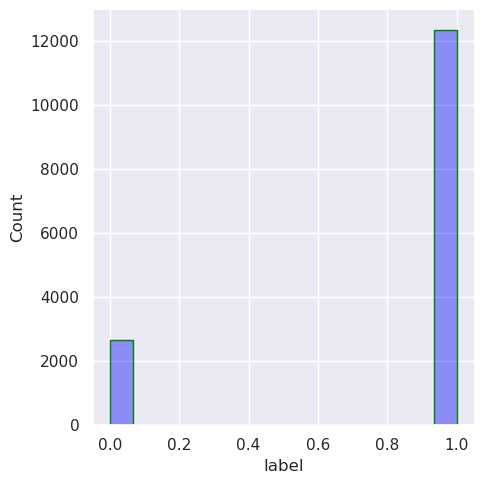

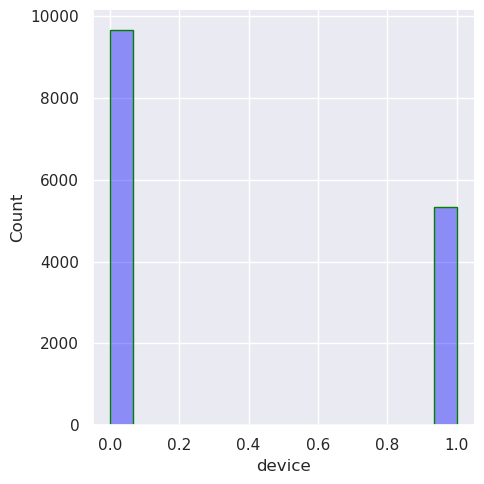

In [83]:
## Balance checking

def pct_checker(percentage, min_percentage, max_percentage):
    if percentage >= min_percentage and percentage <= max_percentage:
        return ('This is the way, balance')
    else:
        return ('not balance, unfortunately This is not the way')

print('------- CLASS COUNTS --------------------')
print()
for obj in cats:
    sns.displot(df_filled, x=obj, color='blue', edgecolor='green', alpha=0.4)
    print(f'---------{str.upper(obj)}--------------------')
    print(df_filled[obj].value_counts())
    
    a = df_filled[obj].value_counts()[0]
    b = df_filled[obj].value_counts()[1]
    pct_a = a / ( a + b ) * 100
    pct_b = b / ( a + b ) * 100
    
    print(f'{b}, is: {round(pct_b, 4)}% of the total')
    print(f'{a}, is: {round(pct_a, 4)}% of the total')
    
    ##
    ## As pct depend of each other we just need one check
    print(pct_checker(pct_a, 40, 60))
 
    print('------------------------------------------')
    print(df[obj].describe())
    print('------------------------------------------')

In [84]:
## And Upsampleing the minority classes.

def upsample_minority_class(data, feature):
    
    '''
    Take a pandas df and one binary feature.
    identify the minority class,
    upsamples the minority in a binary class in a DataFrame 
    to match the size of the majority class.

      Args:
        data: The DataFrame to be upsampled, pandas Data Frame.
        feature: the columns name, string.
        
      Returns:
        A DataFrame with the minority class upsampled.
    '''
    
    ## Identify data points from majority and minority classes
    
    class_1 = data[feature].value_counts().index[0]
    class_2 = data[feature].value_counts().index[1]
    
    majority_class = None
    minority_class = None

    if class_1 > class_2:
        majority_class = class_1
        minority_class = class_2
    else: 
        majority_class = class_2
        minority_class = class_1

    
    data_majority = data[data[feature] == majority_class]
    data_minority = data[data[feature] == minority_class]
    
    n_samples = len(data_majority)
                              
    data_minority_upsampled = resample(
          data_minority,
          replace=True,
          n_samples=n_samples,
          random_state=None)

    data_upsampled = pd.concat([data_majority, \
                                data_minority_upsampled]).reset_index(drop=True)

    return data_upsampled


In [85]:
df1 = upsample_minority_class(df_filled, 'label')
df2 = upsample_minority_class(df1, 'device')

------- CLASS COUNTS --------------------

---------LABEL--------------------
0    8707
1    8697
Name: label, dtype: int64
8697, is: 49.9713% of the total
8707, is: 50.0287% of the total
This is the way, balance
------------------------------------------
count     17404
unique        2
top           0
freq       8707
Name: label, dtype: int64
------------------------------------------
---------DEVICE--------------------
1    8702
0    8702
Name: device, dtype: int64
8702, is: 50.0% of the total
8702, is: 50.0% of the total
This is the way, balance
------------------------------------------
count     17404
unique        2
top           1
freq       8702
Name: device, dtype: int64
------------------------------------------


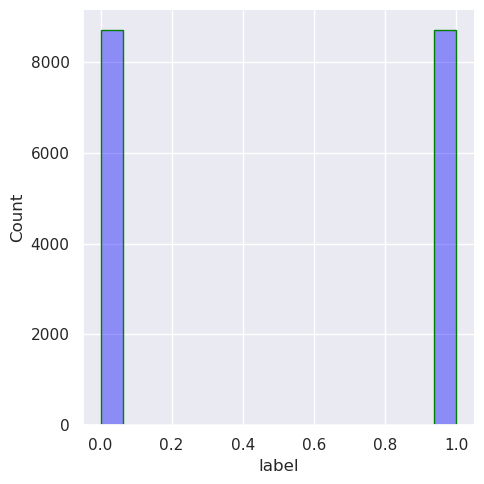

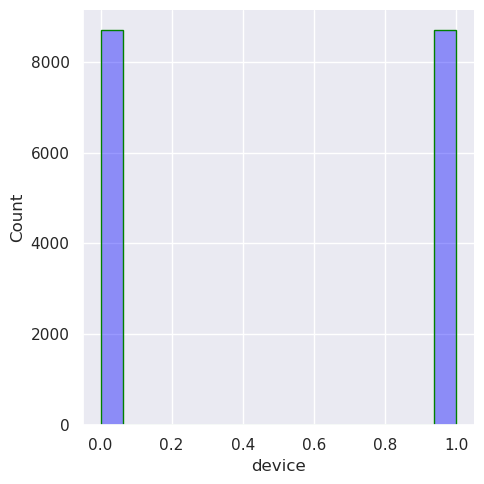

In [86]:
## Balance checking validation

def pct_checker(percentage, min_percentage, max_percentage):
    if percentage >= min_percentage and percentage <= max_percentage:
        return ('This is the way, balance')
    else:
        return ('not balance, unfortunately This is not the way')

print('------- CLASS COUNTS --------------------')
print()
for obj in ['label', 'device']:
    sns.displot(df2, x=obj, color='blue', edgecolor='green', alpha=0.4)
    print(f'---------{str.upper(obj)}--------------------')
    print(df2[obj].value_counts())
    
    a = df2[obj].value_counts()[0]
    b = df2[obj].value_counts()[1]
    pct_a = a / ( a + b ) * 100
    pct_b = b / ( a + b ) * 100
    
    print(f'{b}, is: {round(pct_b, 4)}% of the total')
    print(f'{a}, is: {round(pct_a, 4)}% of the total')
    
    ##
    ## As pct depend of each other we just need one check
    print(pct_checker(pct_a, 40, 60))
 
    print('------------------------------------------')
    print(df2[obj].describe())
    print('------------------------------------------')

In [87]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17404 entries, 0 to 17403
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    17404 non-null  object 
 1   sessions                 17404 non-null  int64  
 2   drives                   17404 non-null  int64  
 3   total_sessions           17404 non-null  float64
 4   n_days_after_onboarding  17404 non-null  int64  
 5   total_navigations_fav1   17404 non-null  int64  
 6   total_navigations_fav2   17404 non-null  int64  
 7   driven_km_drives         17404 non-null  float64
 8   duration_minutes_drives  17404 non-null  float64
 9   activity_days            17404 non-null  int64  
 10  driving_days             17404 non-null  int64  
 11  device                   17404 non-null  object 
dtypes: float64(3), int64(7), object(2)
memory usage: 1.6+ MB


In [88]:
## Now continious variables.

nums

Index(['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding',
       'total_navigations_fav1', 'total_navigations_fav2', 'driven_km_drives',
       'duration_minutes_drives', 'activity_days', 'driving_days'],
      dtype='object')

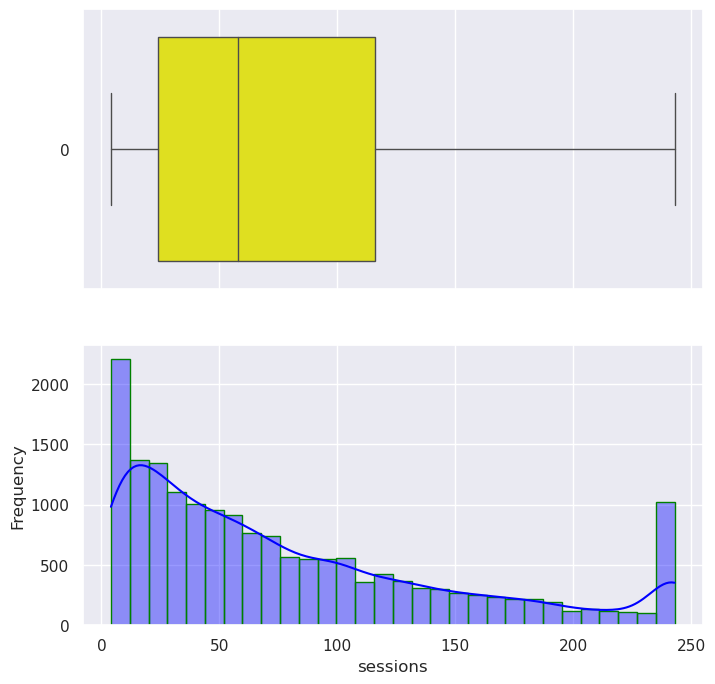

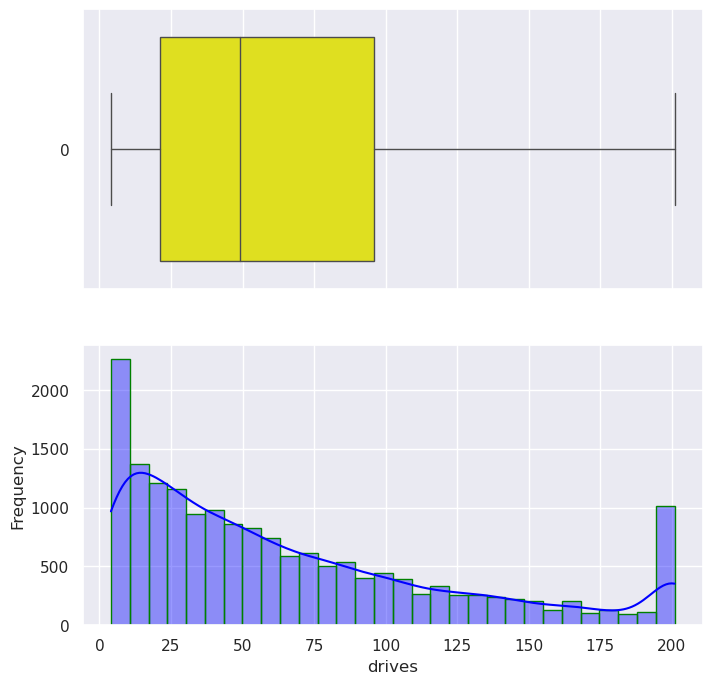

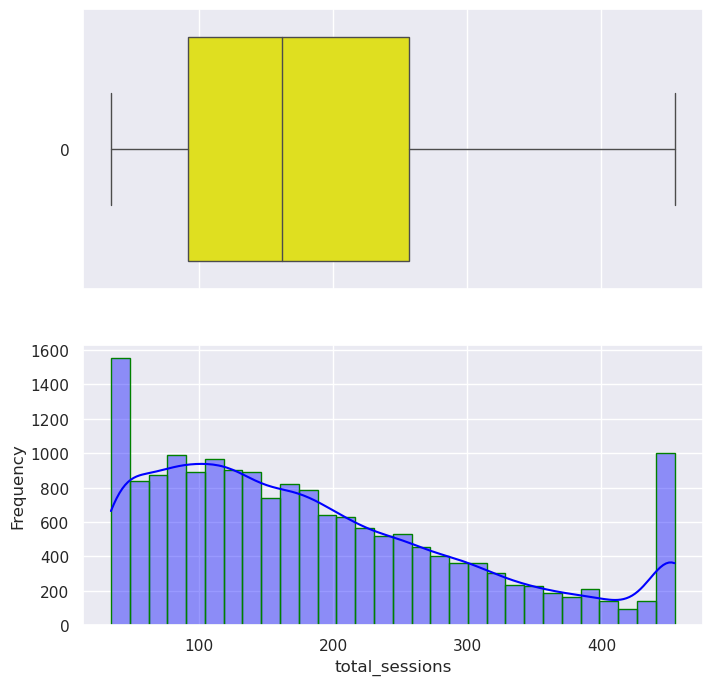

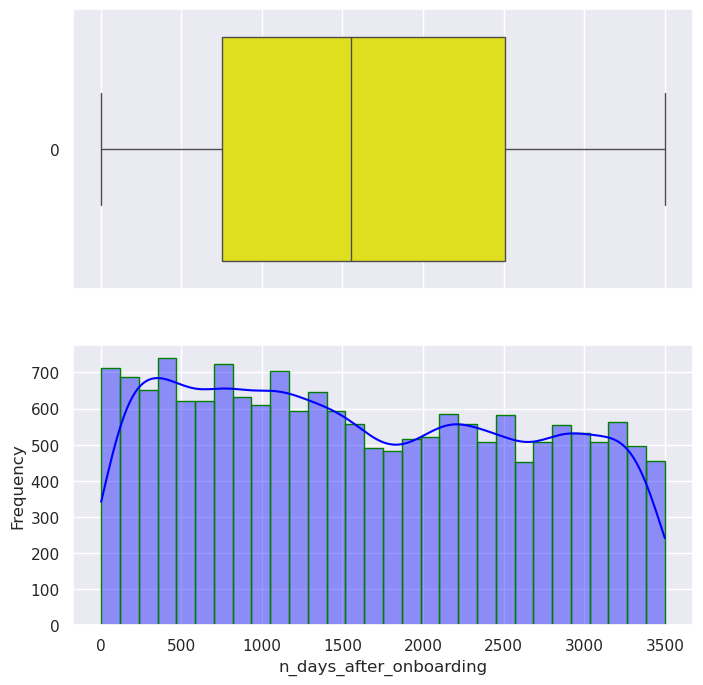

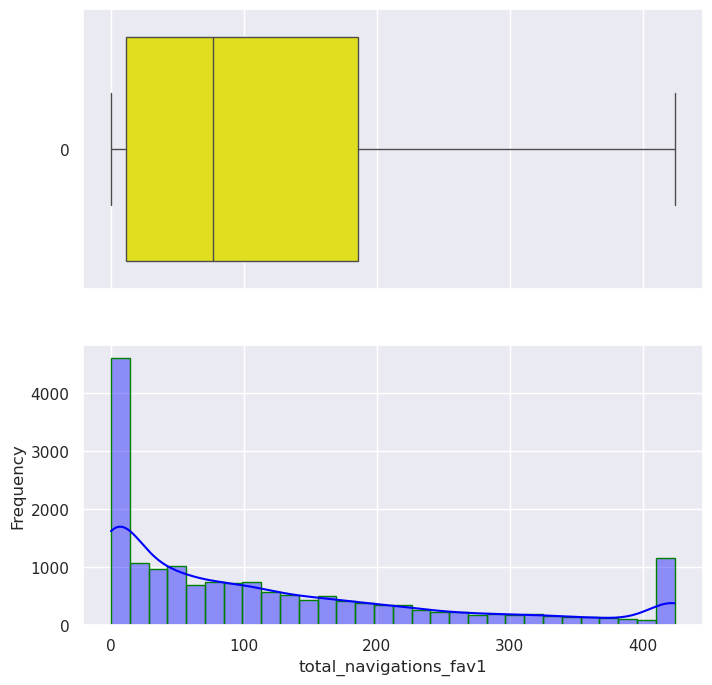

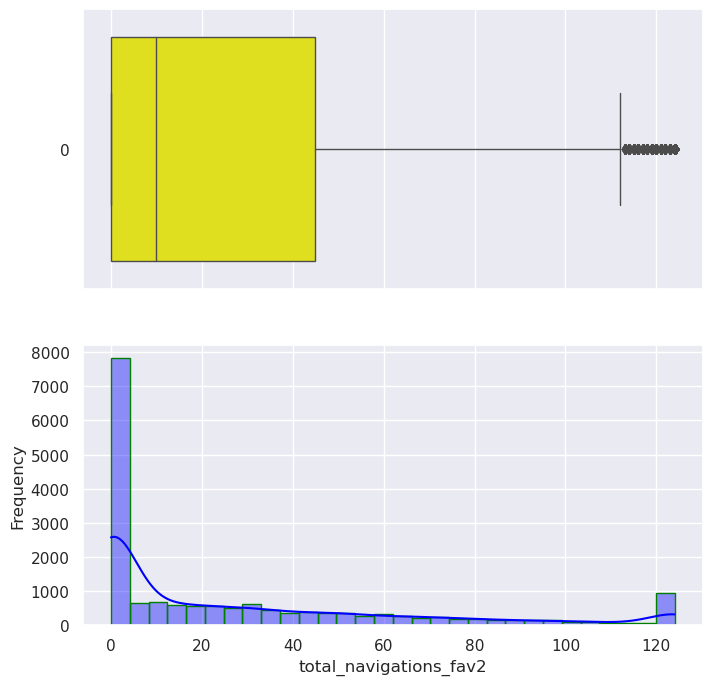

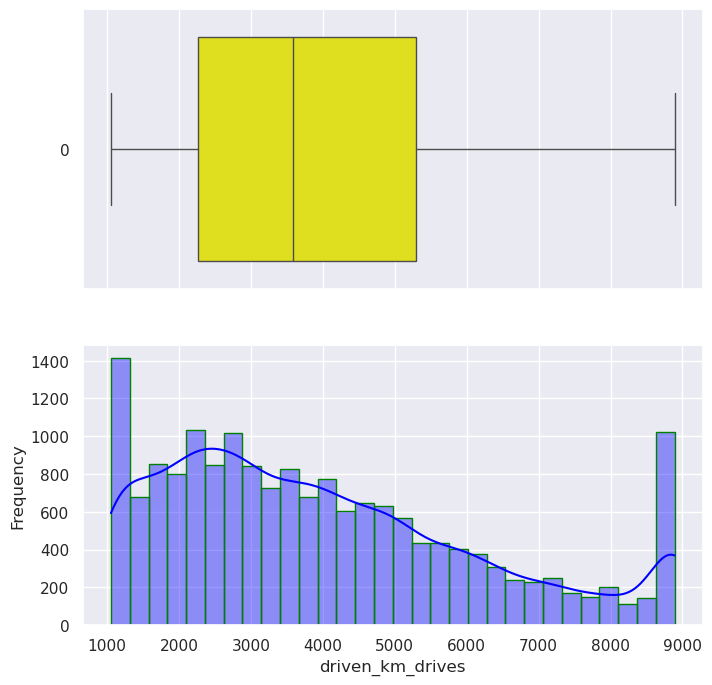

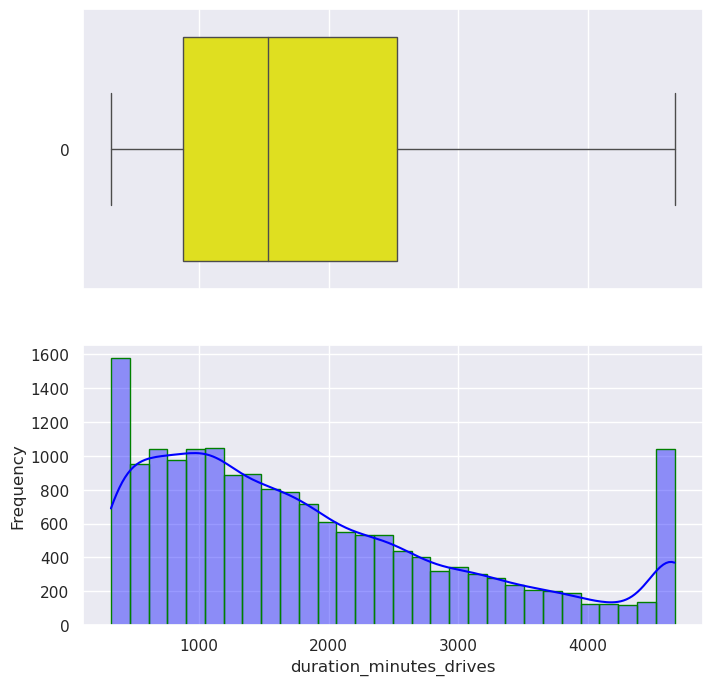

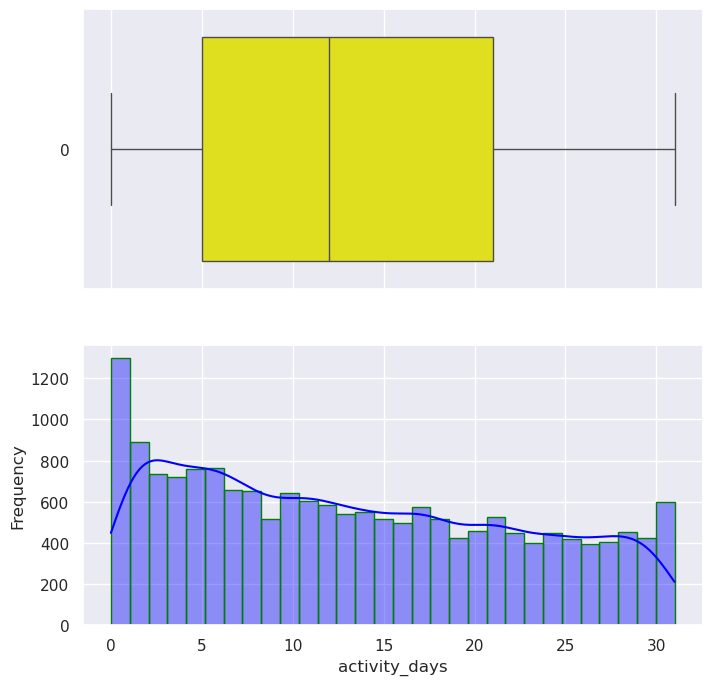

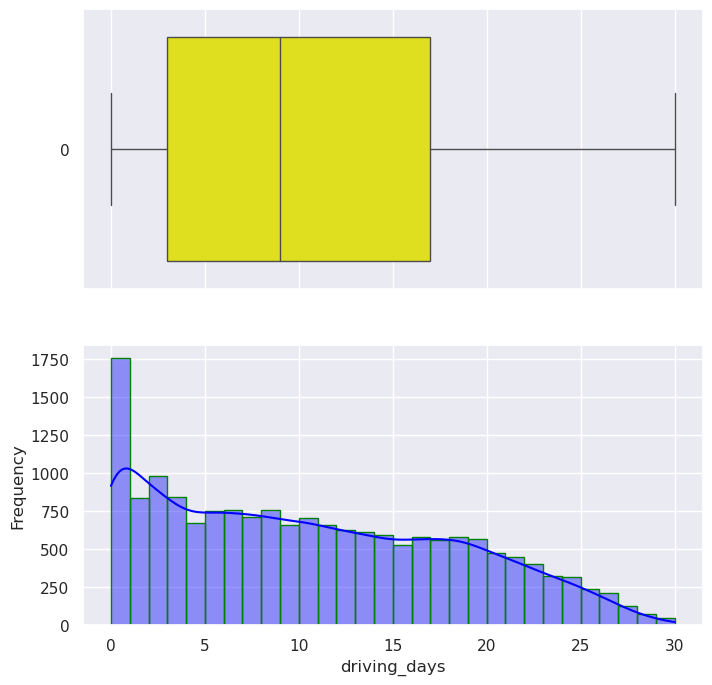

In [89]:
## Observing Distribution of the continious variables.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df2[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df2[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

## Notes

At first we can notice not normality.
We will notice that the log transformation of some features tend to fits better into normality that the not transformed.

This features seems to do not benefit that much.
- `'n_days_after_onboarding'`
- `'activity_days'`
- `'driving_days'`


## Note:
np.log(0) = -inf
instead of using the log we will use the `np.log1p()`
The `np.log1p()` function in NumPy returns the natural logarithm of one plus the input array, element-wise. It calculates `log(1 + x)`.

In [90]:
np.log(0), np.log(0.000001)

(-inf, -13.815510557964274)

In [91]:
np.log1p(0), np.log(0.000001)

(0.0, -13.815510557964274)

In [92]:
## Transforming
for col in to_transform:
    df[col] = np.log1p(df[col])

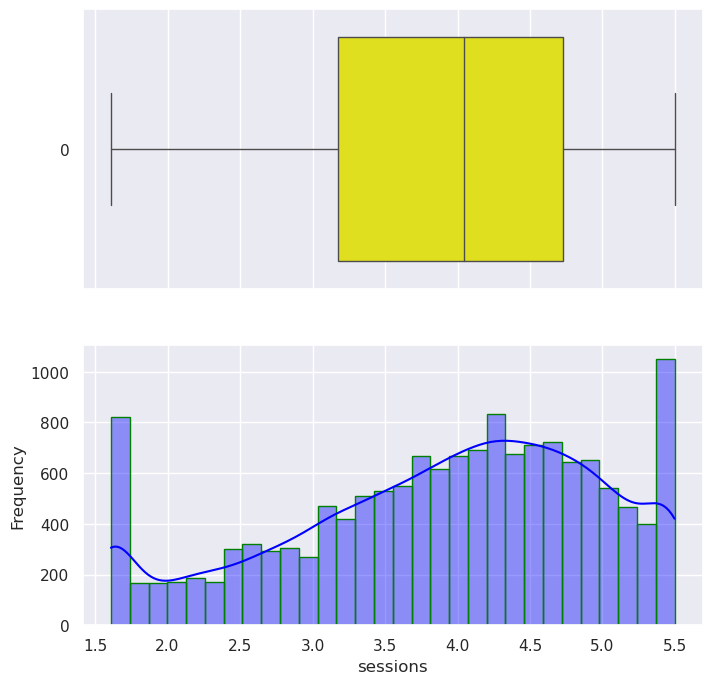

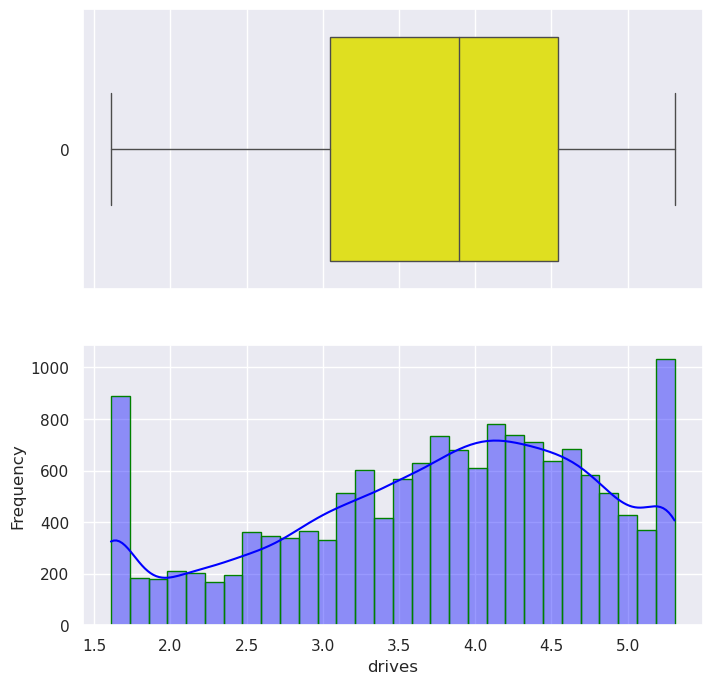

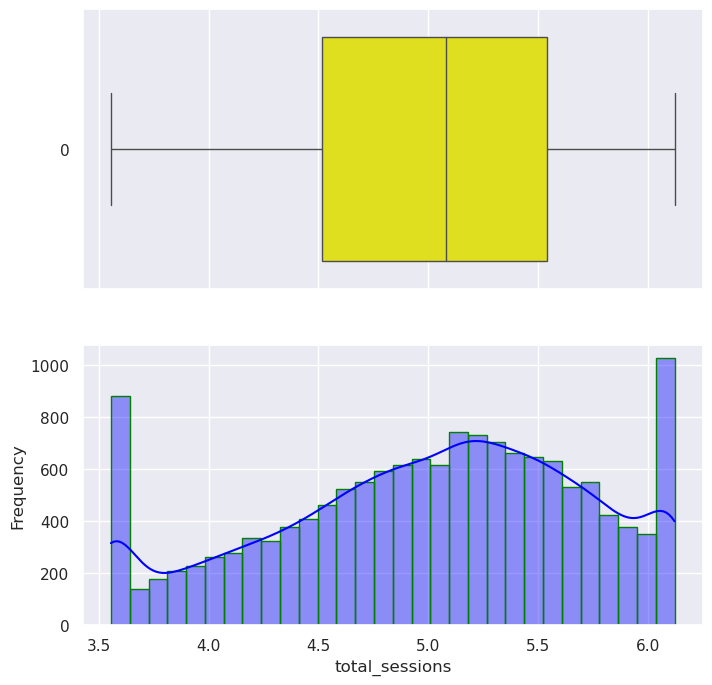

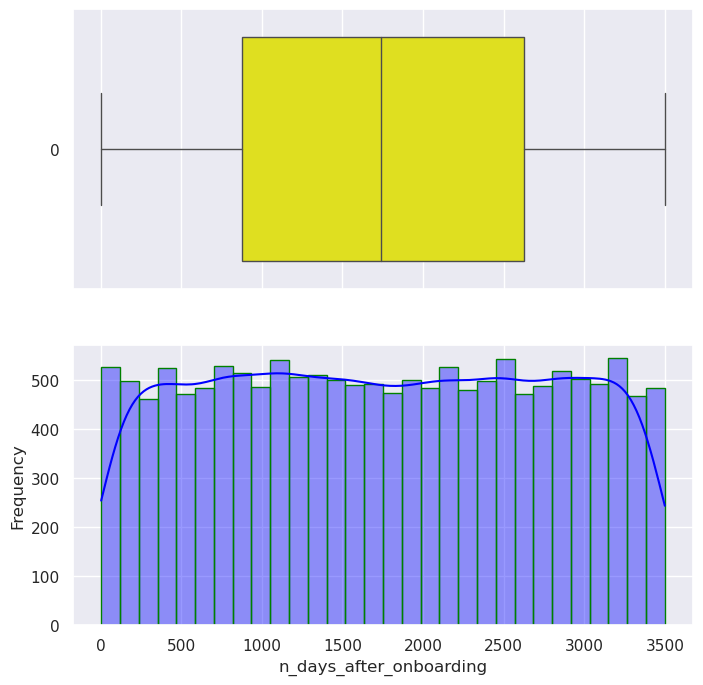

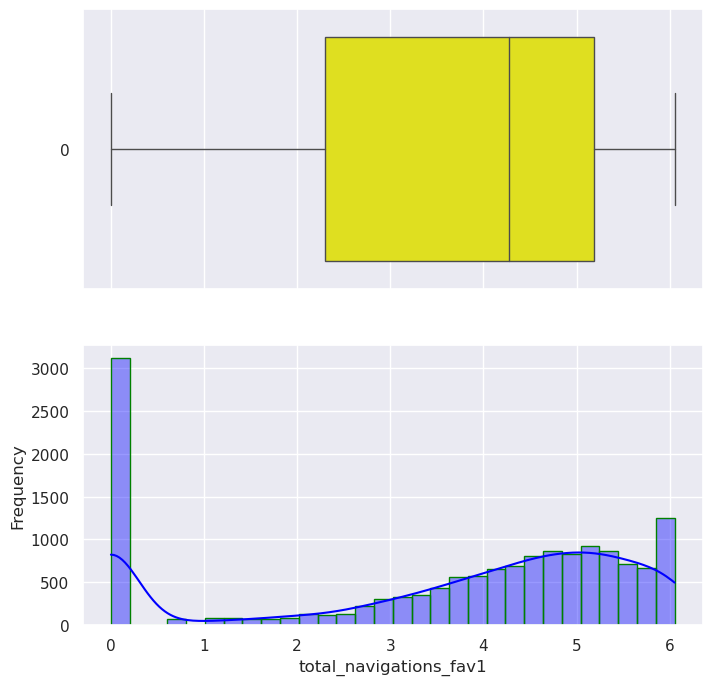

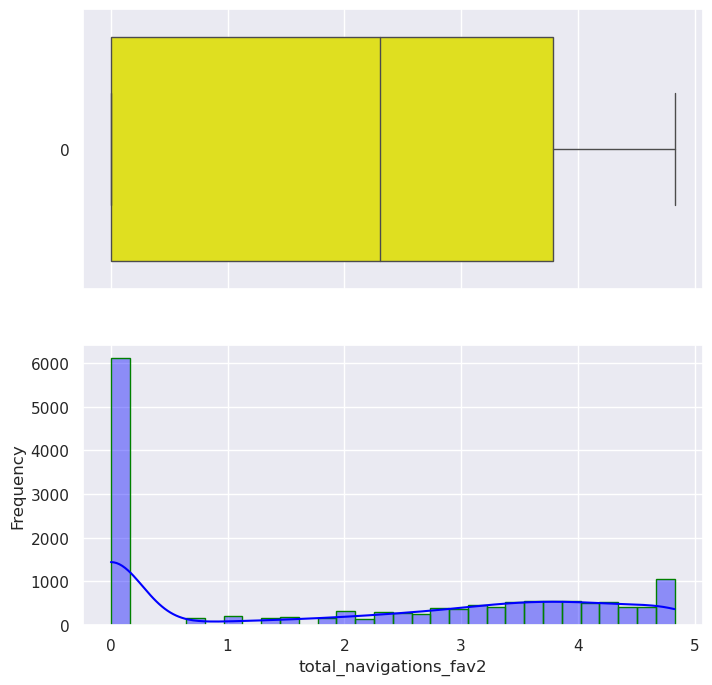

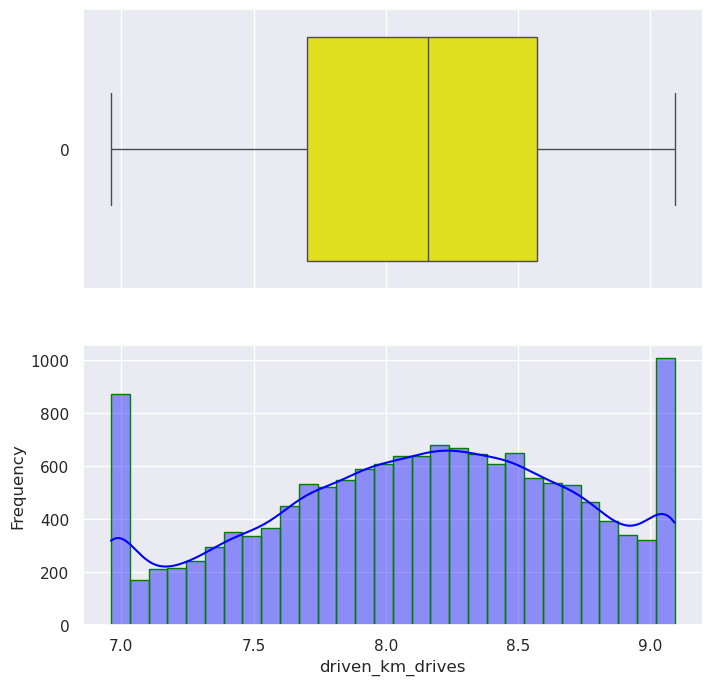

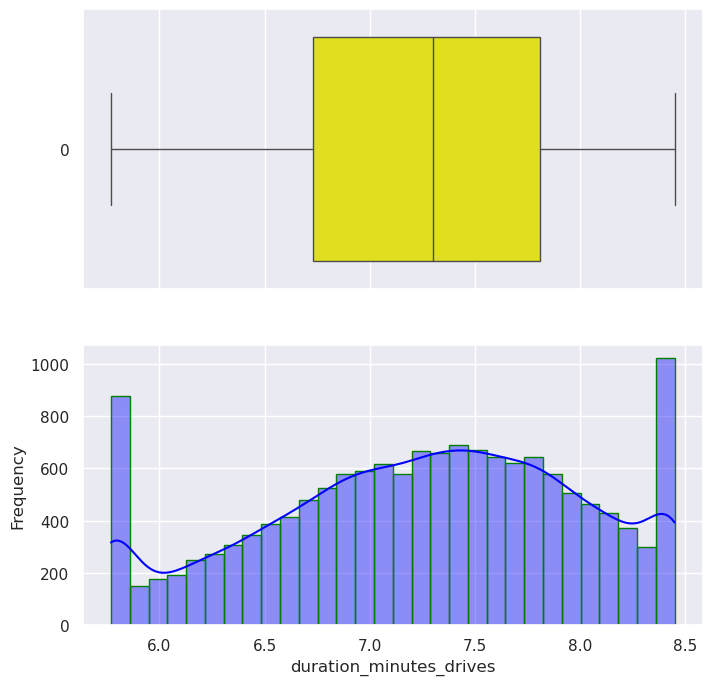

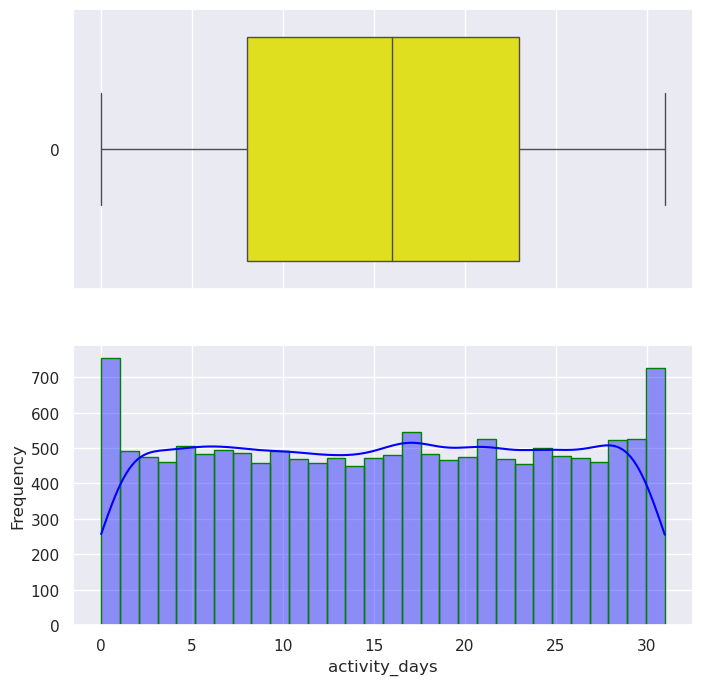

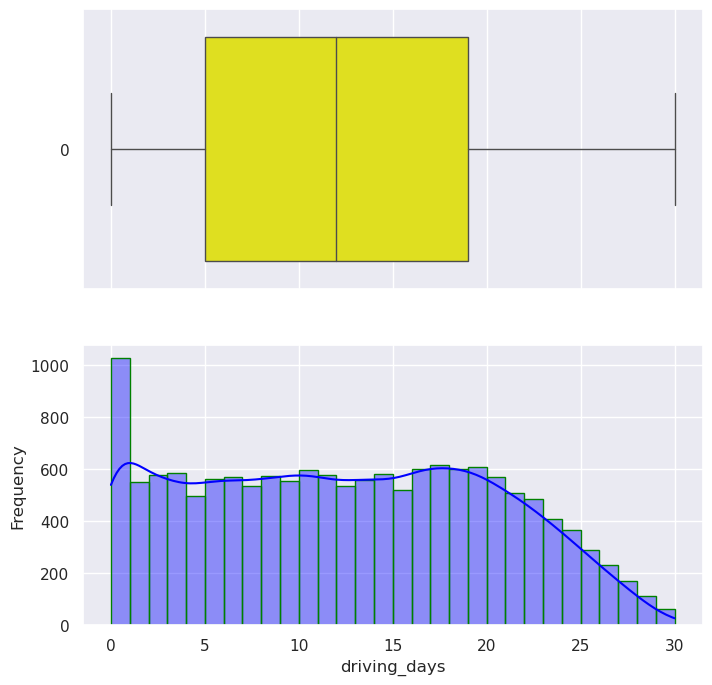

In [93]:
## Observing Distribution of the continious variables transformed.

for i in df[nums]:
    sns.set(rc={"figure.figsize":(8, 8)});
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True)
    plt.gca().set(xlabel= i,ylabel='Frequency');
    
    sns.boxplot(df[i], orient='h', ax=ax_box , linewidth= 1.0, color='yellow');
    sns.histplot(df[i], ax=ax_hist , bins = 30, kde=True, color='blue', edgecolor='green', alpha=0.4);

In [94]:
df2['label'] = df2['label'].astype(int)
df2['device'] = df2['device'].astype(int)

In [95]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17404 entries, 0 to 17403
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    17404 non-null  int64  
 1   sessions                 17404 non-null  int64  
 2   drives                   17404 non-null  int64  
 3   total_sessions           17404 non-null  float64
 4   n_days_after_onboarding  17404 non-null  int64  
 5   total_navigations_fav1   17404 non-null  int64  
 6   total_navigations_fav2   17404 non-null  int64  
 7   driven_km_drives         17404 non-null  float64
 8   duration_minutes_drives  17404 non-null  float64
 9   activity_days            17404 non-null  int64  
 10  driving_days             17404 non-null  int64  
 11  device                   17404 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.6 MB


In [96]:
df2.head()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,1,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1
1,1,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1
2,1,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1
3,1,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,1
4,1,80,64,132.830506,3154,39,16,8531.248070,4669.675626,1,0,1


Assuptions for our model

Independent observations (This refers to how the data was collected.)

No extreme outliers

Little to no multicollinearity among X predictors

Linear relationship between X and the logit of y

In [97]:
## 
corr = df2.corr()
df2.corr()

,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
label,1.000000,-0.054697,-0.055256,-0.029896,0.177146,-0.062340,0.007070,-0.017597,-0.041387,0.371663,0.361135,0.011147
sessions,-0.054697,1.000000,0.996843,0.597660,0.012232,0.017210,0.009393,0.007934,-0.004074,0.001420,-0.000328,0.014844
drives,-0.055256,0.996843,1.000000,0.596023,0.009295,0.016604,0.010114,0.008806,-0.003504,0.001493,-0.000367,0.015927
total_sessions,-0.029896,0.597660,0.596023,1.000000,0.011171,0.005798,0.013297,0.001786,0.000908,0.010835,0.007766,0.008509
n_days_after_onboarding,0.177146,0.012232,0.009295,0.011171,1.000000,-0.012758,-0.009823,-0.011099,-0.020009,0.014550,0.012834,-0.008065
total_navigations_fav1,-0.062340,0.017210,0.016604,0.005798,-0.012758,1.000000,0.015022,-0.011998,0.004048,0.015258,0.016672,0.011889
total_navigations_fav2,0.007070,0.009393,0.010114,0.013297,-0.009823,0.015022,1.000000,-0.006549,-0.009187,0.011436,0.019065,-0.008555
driven_km_drives,-0.017597,0.007934,0.008806,0.001786,-0.011099,-0.011998,-0.006549,1.000000,0.703540,-0.012943,-0.017110,-0.002485
duration_minutes_drives,-0.041387,-0.004074,-0.003504,0.000908,-0.020009,0.004048,-0.009187,0.703540,1.000000,-0.022818,-0.026733,0.007328
activity_days,0.371663,0.001420,0.001493,0.010835,0.014550,0.015258,0.011436,-0.012943,-0.022818,1.000000,0.951554,0.018000


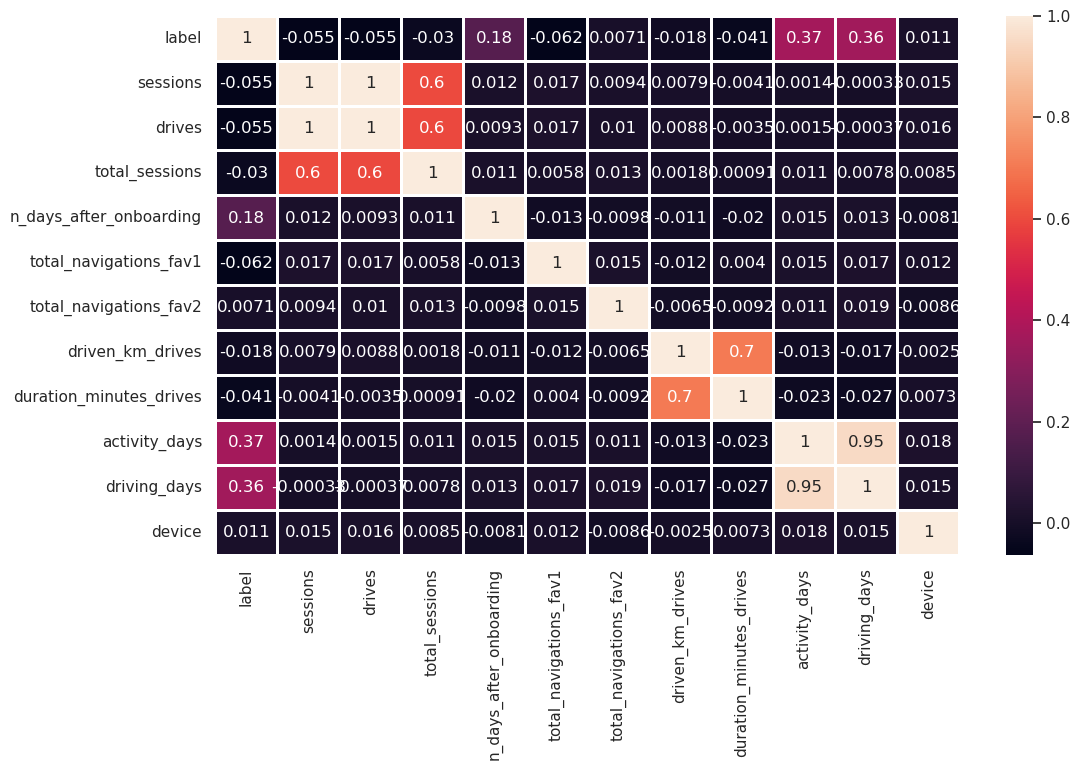

In [98]:
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corr, annot=True, linewidths=1, ax=ax);

In [99]:
high_corr = ['label','activity_days', 'driving_days']
df2[high_corr].corr()

,label,activity_days,driving_days
label,1.000000,0.371663,0.361135
activity_days,0.371663,1.000000,0.951554
driving_days,0.361135,0.951554,1.000000


In [100]:
df2.columns

Index(['label', 'sessions', 'drives', 'total_sessions',
       'n_days_after_onboarding', 'total_navigations_fav1',
       'total_navigations_fav2', 'driven_km_drives', 'duration_minutes_drives',
       'activity_days', 'driving_days', 'device'],
      dtype='object')

In [102]:
X_not_scaled = df2.iloc[:, 1:]
y = df2.iloc[:,0]

In [103]:
X_not_scaled.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,243,201,296.748273,2276,208,0,2628.845068,1985.775061,28,19,1
1,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,1
2,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,1
3,57,46,183.532018,424,0,26,2651.709764,1594.342984,25,20,1
4,80,64,132.830506,3154,39,16,8531.248070,4669.675626,1,0,1


In [104]:
## Scaling X_not_scaled

scaler = StandardScaler()
scaler.fit(X_not_scaled)

X_ = scaler.transform(X_not_scaled) ## this returns a np array
## to keep index and column as before we do as follow.

X = pd.DataFrame(X_, index=X_not_scaled.index, columns=X_not_scaled.columns)
X.describe()


,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
count,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,1.740400e+04,17404.000000
mean,-2.945179e-16,1.358754e-16,-3.099553e-16,1.570987e-16,-4.361663e-16,-3.217695e-16,-2.809877e-16,1.073734e-16,2.825965e-15,-4.822619e-17,0.000000
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029
min,-1.093560e+00,-1.101806e+00,-1.291339e+00,-1.613159e+00,-9.353527e-01,-7.541212e-01,-1.344569e+00,-1.240661e+00,-1.488913e+00,-1.343269e+00,-1.000000
25%,-8.020750e-01,-8.004995e-01,-7.998502e-01,-8.728737e-01,-8.496709e-01,-7.541212e-01,-7.920533e-01,-7.888820e-01,-9.324691e-01,-9.544026e-01,-1.000000
50%,-3.065512e-01,-3.042308e-01,-2.065206e-01,-8.330188e-02,-3.355802e-01,-4.821687e-01,-1.880370e-01,-2.477090e-01,-1.534474e-01,-1.766700e-01,0.000000
75%,5.387541e-01,5.287917e-01,6.017099e-01,8.583192e-01,5.134485e-01,4.696649e-01,5.990848e-01,5.643919e-01,8.481520e-01,8.603066e-01,1.000000
max,2.389681e+00,2.389799e+00,2.285573e+00,1.832962e+00,2.367291e+00,2.618090e+00,2.241902e+00,2.314602e+00,1.961040e+00,2.545394e+00,1.000000


In [110]:
X.head()

,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,2.389681,2.389799,0.943338,0.626426,0.684812,-0.754121,-0.623457,0.121200,1.627174,1.119551,1.0
1,0.509606,0.511068,-0.427930,0.996075,-0.935353,-0.754121,-0.426531,-0.185299,0.069130,-0.306292,1.0
2,0.072379,0.032523,-0.149602,-0.077387,0.357663,-0.618145,-0.018746,-0.504989,1.515885,0.989929,1.0
3,-0.321125,-0.357402,-0.019599,-1.199151,-0.935353,-0.047045,-0.612993,-0.198696,1.293307,1.249173,1.0
4,0.014082,-0.038373,-0.450830,1.491899,-0.631572,-0.318997,2.077740,2.314602,-1.377624,-1.343269,1.0


In [117]:
## Splitting the data

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12182, 11), (5222, 11), (12182,), (5222,))

accuracy score: 0.6815396399846801
# of iterations 25


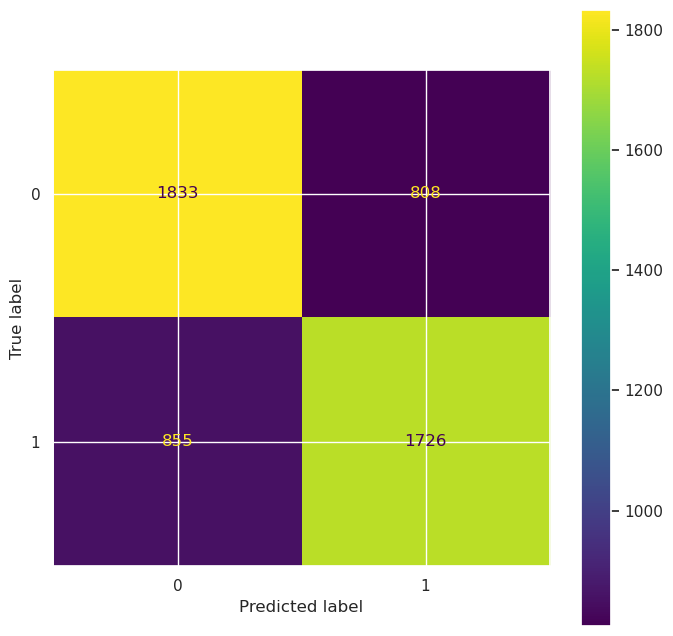

In [118]:
## Fitting the model to the data, and saving it as a variable

clf01 = LogisticRegression().fit(X_train, y_train)

## Obtaining predictions
y_pred = clf01.predict(X_test)

print('accuracy score: %s' % clf01.score(X_test, y_test))
print('# of iterations %s' % clf01.n_iter_[0])

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = clf01.classes_)
# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf01.classes_)
# Display the confusion matrix
disp.plot();

In [119]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.68      0.69      0.69      2641
not verified       0.68      0.67      0.67      2581

    accuracy                           0.68      5222
   macro avg       0.68      0.68      0.68      5222
weighted avg       0.68      0.68      0.68      5222



In [ ]:
# Get the feature names from the model and the model coefficients (which represent log-odds ratios)
# Place into a DataFrame for readability
pd.DataFrame(data={"Feature Name":clf01.feature_names_in_, "Model Coefficient":clf01.coef_[0]})

____

In [111]:
X2 = X.drop(columns = ['device', 'sessions', 'driving_days'])
X2

,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days
0,2.389799,0.943338,0.626426,0.684812,-0.754121,-0.623457,0.121200,1.627174
1,0.511068,-0.427930,0.996075,-0.935353,-0.754121,-0.426531,-0.185299,0.069130
2,0.032523,-0.149602,-0.077387,0.357663,-0.618145,-0.018746,-0.504989,1.515885
3,-0.357402,-0.019599,-1.199151,-0.935353,-0.047045,-0.612993,-0.198696,1.293307
4,-0.038373,-0.450830,1.491899,-0.631572,-0.318997,2.077740,2.314602,-1.377624
...,...,...,...,...,...,...,...,...
17399,-0.339679,-0.753259,-0.127660,-0.935353,1.475889,-1.344569,-1.055630,0.402997
17400,2.035322,1.363821,-0.391836,2.001196,1.503084,0.421345,0.313805,0.959441
17401,-0.339679,0.269618,1.090706,-0.569258,-0.754121,-0.852532,-0.713423,-1.043758
17402,0.067971,0.454261,-1.156765,-0.062956,0.170517,1.055775,1.587618,0.402997


accuracy score: 0.6744542320949828
# of iterations 9


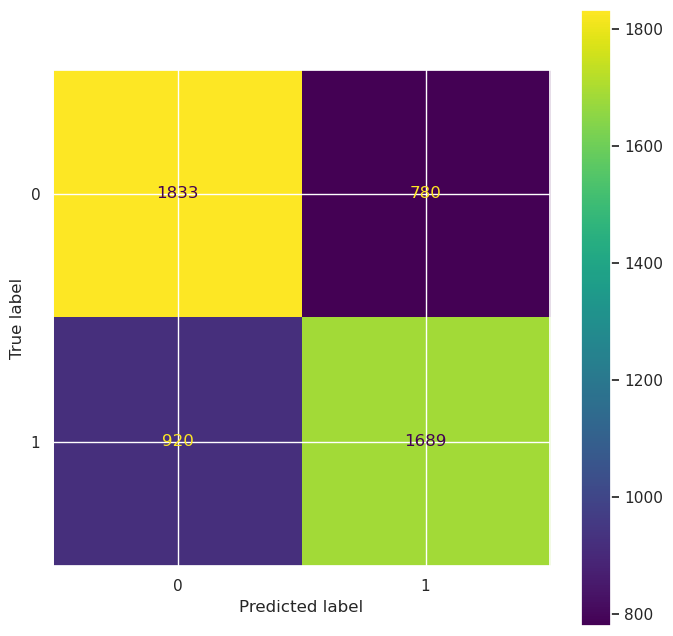

In [114]:
## Fitting the model to the data, and saving it as a variable
X2 = X.drop(columns = ['device', 'sessions', 'driving_days'])
y2 = y

# Split the data into training and testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, stratify=y, random_state=42)
X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape

clf02 = LogisticRegression(penalty='none', max_iter=400).fit(X2_train, y2_train)

## Obtaining predictions
y2_pred = clf02.predict(X2_test)

print('accuracy score: %s' % clf02.score(X2_test, y2_test))
print('# of iterations %s' % clf02.n_iter_[0])

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y2_test, y2_pred, labels = clf02.classes_)
# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf02.classes_)
# Display the confusion matrix
disp.plot();

In [133]:
# Create classification report for logistic regression model
target_labels = ["verified", "not verified"]
print(classification_report(y2_test, y2_pred, target_names=target_labels))

              precision    recall  f1-score   support

    verified       0.67      0.70      0.68      2613
not verified       0.68      0.65      0.67      2609

    accuracy                           0.67      5222
   macro avg       0.67      0.67      0.67      5222
weighted avg       0.67      0.67      0.67      5222



In [116]:
pd.Series(clf02.coef_[0], index=X2.columns)

drives                    -0.129357
total_sessions             0.010895
n_days_after_onboarding    0.422067
total_navigations_fav1    -0.156687
total_navigations_fav2     0.030815
driven_km_drives           0.041930
duration_minutes_drives   -0.128451
activity_days              0.852359
dtype: float64

In [120]:
clf02.intercept_

array([0.00868972])

In [124]:
## Verify the linear relationship between X and the 
## estimated log odds (known as logits) by making a regplot.

# Get the predicted probabilities of the training data
models = [clf02, clf01]

training_probabilities1 = clf01.predict_proba(X_train)
print(training_probabilities1)
training_probabilities2 = clf02.predict_proba(X2_train)
print(training_probabilities2)

[[0.69599082 0.30400918]
 [0.60374959 0.39625041]
 [0.57879778 0.42120222]
 ...
 [0.62407357 0.37592643]
 [0.40657466 0.59342534]
 [0.41082968 0.58917032]]
[[0.46195226 0.53804774]
 [0.32715208 0.67284792]
 [0.13891516 0.86108484]
 ...
 [0.33187496 0.66812504]
 [0.52870736 0.47129264]
 [0.10636489 0.89363511]]


In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

1. Create a dataframe called `logit_data` that is a copy of `df`.

2. Create a new column called `logit` in the `logit_data` dataframe. The data in this column should represent the logit for each user.


In [125]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities1]

# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data2 = X2_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data2['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities2]

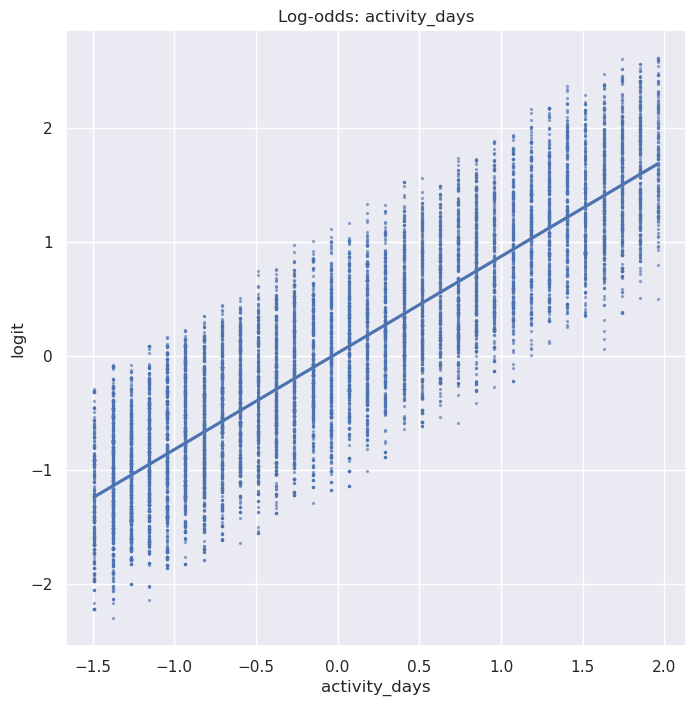

In [126]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds: activity_days');

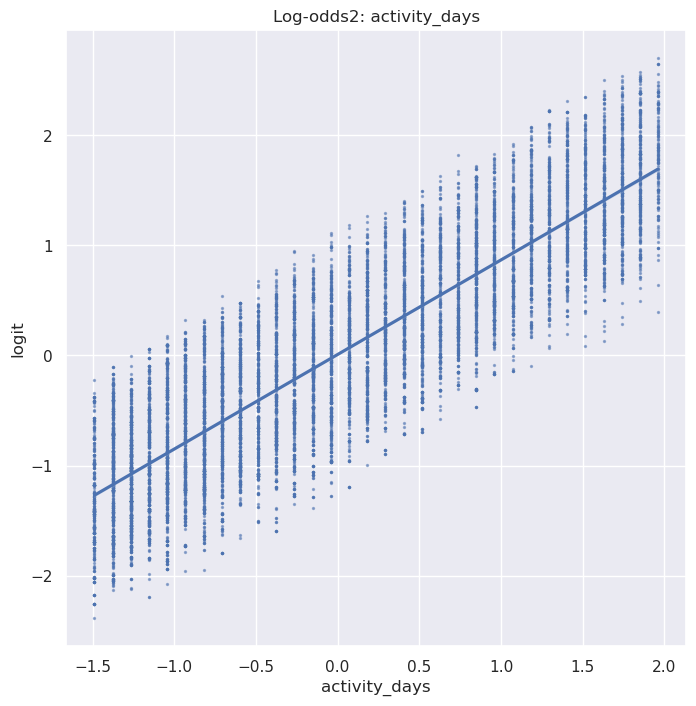

In [127]:
# Plot regplot of `activity_days` log-odds
sns.regplot(x='activity_days', y='logit', data=logit_data2, scatter_kws={'s': 2, 'alpha': 0.5})
plt.title('Log-odds2: activity_days');

In [128]:
# Generate predictions on X_test
y_preds = clf01.predict(X_test)

In [130]:
# Generate predictions on X_test
y_preds2 = clf02.predict(X2_test)

In [131]:
# Score the model (accuracy) on the test data
clf01.score(X_test, y_test)

0.6815396399846801

In [132]:
# Score the model (accuracy) on the test data
clf02.score(X2_test, y2_test)

0.6744542320949828

In [134]:
# Create a list of (column_name, coefficient) tuples
feature_importance = list(zip(X_train.columns, clf01.coef_[0]))

# Sort the list by coefficient value
feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)
feature_importance

[('activity_days', 0.5977181687566472),
 ('n_days_after_onboarding', 0.409245052491662),
 ('driving_days', 0.25778609759396637),
 ('driven_km_drives', 0.043193141885490983),
 ('total_navigations_fav2', 0.01801647982570738),
 ('device', 0.009187232552620864),
 ('drives', 0.00810488929783211),
 ('total_sessions', -0.03614574353882907),
 ('duration_minutes_drives', -0.06730962422330564),
 ('sessions', -0.13225725776309233),
 ('total_navigations_fav1', -0.15562603562573854)]

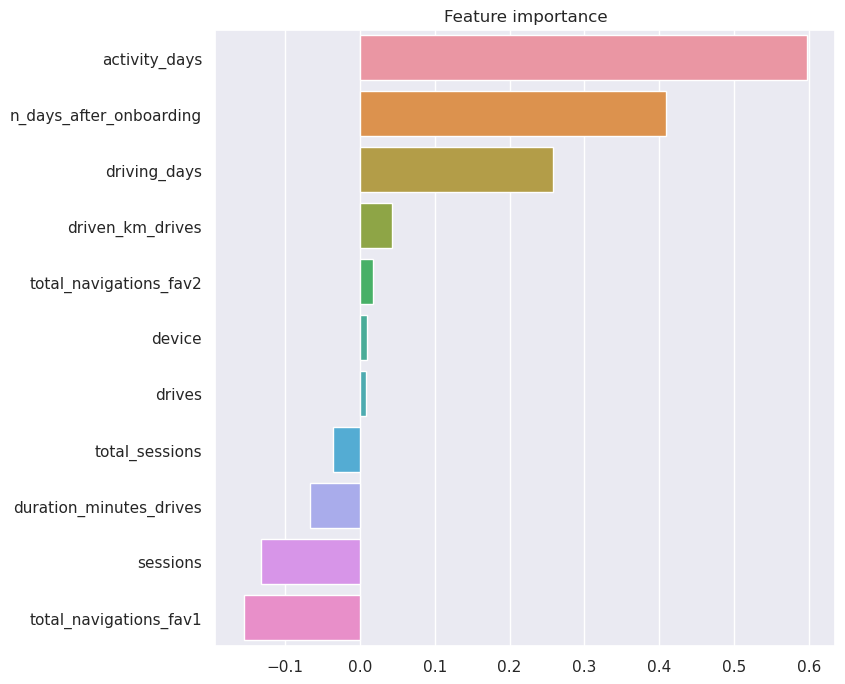

In [135]:
# Plot the feature importances
import seaborn as sns
sns.barplot(x=[x[1] for x in feature_importance],
            y=[x[0] for x in feature_importance],
            orient='h')
plt.title('Feature importance');

### **Task 4c. Conclusion**

Now that you've built your regression model, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**


1. What variable most influenced the model's prediction? How? Was this surprising?

> _`activity_days` was by the most important feature in the model. 

2. Were there any variables that you expected to be stronger predictors than they were?

> _Yes. `n_days_after_onboarding` and `driving days`.

3. Why might a variable you thought to be important not be important in the model?

> _In a multiple logistic regression model, features can interact with each other and these interactions can result in seemingly counterintuitive relationships. This is both a strength and a weakness of predictive models, as capturing these interactions typically makes a model more predictive while at the same time making the model more difficult to explain._

4. Would you recommend that Waze use this model? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor with 68% accuracy

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, one of the engineered features (`professional_driver`) was the third-most-predictive predictor. It could also be helpful to scale the predictor variables, and/or to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._